# <a id='top'>Covid-19 Data Analysis</a>

The purpose of this project is to clean, explore, and draw insights from the [Johns Hopkins COVID-19 dataset](https://data.world/associatedpress/johns-hopkins-coronavirus-case-tracker) and the [State and Policy Orders dataset](https://catalog.data.gov/dataset/covid-19-state-and-county-policy-orders) from data.gov. New case and death data is visualized at the state and county level and correlated with policy implementations. Finally, a regression model is being developed to estimate the expected number of new cases and deaths given the policy implementations since the start of the pandemic. At the moment, the most hopeful candidate model is Decision Tree regression with $R^2 \approx 0.25$. 

### Table of Contents

* 1 [data cleaning](#1)<br>
    * 1.1 [Johns Hopkins](#1.1)<br>
    * 1.2 [State and Policy Orders](#1.2)<br> 
* 2 [data visualization](#2)<br>
    * 2.1 [New Cases and Deaths](#2.1)<br>
    * 2.2 [Policy Data Overlay](#2.2)<br>
* 3 [correlation between cases and policies](#corr)<br>
    * 3.1 [Finding Correlations](#3.1)<br>
    * 3.2 [Evaluating Correlations](#3.2)<br>
* 4 [Regression Modeling](#4)<br>
    * 4.1 [Data preprocessing](#4.1)<br>
    * 4.2 [Test Model](#4.2)<br>
    * 4.3 [Model Selection & Feature Engineering](#4.3)<br> 
* 5 [Conclusions and Future Work](#5)<br>
 

### Associated links: 
- extended discussion of [data cleaning](https://nbviewer.jupyter.org/github/apalermo01/covid-19-data-analysis/blob/main/Covid-19%20data%20cleaning.ipynb)

- [github repo](https://github.com/apalermo01/covid-19-data-analysis)

- [Related paper](https://www.nature.com/articles/s41562-020-01009-0?fbclid=IwAR2fnHNxYtB54oHuyQmz8rEpuypgwvbWvSnY8fOQg7Zt_bLA13HsZZvecrY) on raking interventions at the international scale


# 0 Imports and configurations

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
#di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [1]:
# configuration settings
%reset -f
%config InlineBackend.figure_format = 'svg'

# basics 
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import time
import math
import random

# visualizations
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# miscellaneous
import re
from tabulate import tabulate
from IPython.display import clear_output
import us
import requests
from textwrap import dedent

BIG_FONT = 18
MED_FONT = 12
SMALL_FONT = 9

# 1 <a id='1'>Data Cleaning</a>
[back to top](#top)

First, load each of the datasets. df = Johns Hopkins COVID-19 dataset, df2 = policy dataset. df is queried directly from dataworld, while the policy dataset is scraped from data.gov

Load case and death data

In [2]:
df = pd.read_csv('https://query.data.world/s/jbgdegbanosfmgly7etz2gxqsbhflk')

Use the HTML source to get the file name (changes with each update of the dataset). 

In [3]:
html = requests.get("https://catalog.data.gov/dataset/covid-19-state-and-county-policy-orders").text
policy_file = html.split("a href=\"/dataset/covid-19-state-and-county-policy-orders")[1]\
    .split("<span>plotly</span>")[0]\
    .split("https://plot.ly/external/?url=")[1]\
    .split("\">")[0]
df2 = pd.read_csv(policy_file)

In [4]:
print("Johns Hopkins datset (raw): ")
df.head()

Johns Hopkins datset (raw): 


,uid,location_type,fips_code,location_name,state,date,total_population,cumulative_cases,cumulative_cases_per_100_000,cumulative_deaths,cumulative_deaths_per_100_000,new_cases,new_deaths,new_cases_per_100_000,new_deaths_per_100_000,new_cases_7_day_rolling_avg,new_deaths_7_day_rolling_avg
0,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-22,18181.0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-23,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-24,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-25,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-26,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [5]:
print("State and Policy orders dataset (raw): ")
df2.head()

State and Policy orders dataset (raw): 


,state_id,county,fips_code,policy_level,date,policy_type,start_stop,comments,source,total_phases
0,MS,Hinds,28049.0,county,2020-07-13,Entertainment,start,Policy_Details: Executive Order by Governor Ta...,sip_submission_form: https://www.sos.ms.gov/co...,NaN
1,AZ,NaN,NaN,state,2020-05-16,Houses of Worship,start,Policy_Details: All businesses are open but mu...,sip_submission_form: https://azgovernor.gov/si...,NaN
2,OR,NaN,NaN,state,2020-05-15,Non-Essential Businesses,start,Policy_Details: Currently open: Grocery stores...,sip_submission_form: https://govstatus.egov.co...,NaN
3,ND,Pembina,38067.0,county,2020-09-03,Phase 5,start,Policy_Details: - Most normal activity can res...,sip_submission_form: https://ndresponse.gov/si...,5.0
4,OR,Lane,41039.0,county,2020-05-15,New Phase,start,Policy_Details: Gatherings up to 25 people all...,sip_submission_form: https://www.eugene-or.gov...,NaN


## 1.1 <a id='1.1'>Johns Hopkins Covid-19 dataset</a>
[back to top](#top)

Shorten column names then look for nulls, unexpected data types, and invalid records. A more detailed look at the data cleaning process is found in the data cleaning notebook.  

In [6]:
df.rename(columns={
    'cumulative_cases_per_100_000'  : 'cumulative_cases_1e6', 
    'cumulative_deaths_per_100_000' : 'cumulative_deaths_1e6',
    'new_cases_per_100_000'         : 'new_cases_1e6', 
    'new_deaths_per_100_000'        : 'new_deaths_1e6', 
    'new_cases_7_day_rolling_avg'   : 'new_cases_7day', 
    'new_deaths_7_day_rolling_avg'  : 'new_deaths_7day'
    }, inplace=True)

Summary of expected datatypes and values: 

| column | details | accepted values |
|-----|------|--------|
| uid | Unique location identifier | numpy.int64
| location_type | type of location data | string
| fips_code | Federal Information Processing System code for each location | 5 digit integer
| location_name | location name | string
| state | state name | string
| date | date of record | datetime object
| total_population | county population | positive integer
| cumulative_cases | total number of covid cases | positive integer
| cumulative_cases_1e6 | normalized total covid cases | positive float
| cumulative_deaths | total number of covid deaths | positive integer
| cumulative_deaths_1e6 | normalized total covid deaths | positive float
| new_cases | number of new covid cases | positive integer
| new_deaths | number of new covid deaths | positive integer
| new_cases_1e6 | normalized number of new cases | positive float
| new_deaths_1e6 | normalized number of new deaths | positive float
| new_cases_7day | 7 day average of new cases | positive float
| new_deaths_7day | 7 day average of new deaths | positive float

Check the distribution of numerical fields, number of nulls in each column, and the datatypes present in each column. 

Define a custom function to evaluate nulls and data types. This is primarily for convenience, as df.info() gives similar information but we're interested in the number of nulls and unique datatypes for each series (since by default df.info() writes 'object' when a series has heterogenous datatypes). 

In [7]:
def eval_df(df):
    """Count the number of nulls and list datatypes present in each column in the input DataFrame."""
    
    table = []
    for col in df.columns: 
        table.append([col, df[col].isnull().sum(), set([type(i) for i in df[col].values])])
        
    print(tabulate(table, headers=["field", "num_nulls", "datatypes"]))

In [8]:
df.describe()

,uid,fips_code,total_population,cumulative_cases,cumulative_cases_1e6,cumulative_deaths,cumulative_deaths_1e6,new_cases,new_deaths,new_cases_1e6,new_deaths_1e6,new_cases_7day,new_deaths_7day
count,1.277688e+06,1.273858e+06,1.233260e+06,1.277688e+06,1.233260e+06,1.277688e+06,1.233260e+06,1.274352e+06,1.274352e+06,1.230040e+06,1.230040e+06,1.256977e+06,1.260233e+06
mean,8.352961e+07,3.310136e+04,1.013323e+05,2.067233e+03,2.017278e+03,4.864221e+01,3.911908e+01,2.118499e+01,3.635738e-01,2.180560e+01,4.043161e-01,2.144719e+01,3.786582e-01
std,3.206731e+06,1.861217e+04,3.260459e+05,1.180922e+04,2.917464e+03,2.889837e+02,6.608259e+01,1.443695e+02,5.364529e+00,5.714962e+01,2.663829e+00,1.320351e+02,2.640266e+00
min,6.307200e+07,1.001000e+03,7.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.590000e+03,-3.962000e+03,-5.975850e+03,-1.685400e+02,0.000000e+00,0.000000e+00
25%,8.401811e+07,1.908500e+04,1.121425e+04,3.000000e+00,2.656000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.402921e+07,3.101800e+04,2.595050e+04,1.240000e+02,5.660700e+02,2.000000e+00,7.430000e+00,1.000000e+00,0.000000e+00,3.450000e+00,0.000000e+00,1.860000e+00,0.000000e+00
75%,8.404612e+07,4.713300e+04,6.655225e+04,9.160000e+02,2.974600e+03,1.800000e+01,5.198000e+01,9.000000e+00,0.000000e+00,2.510000e+01,0.000000e+00,1.043000e+01,1.400000e-01
max,8.410000e+07,9.999900e+04,1.009805e+07,1.146483e+06,3.348135e+04,1.804700e+04,8.400200e+02,2.942300e+04,1.553000e+03,9.370100e+03,2.793300e+02,1.607743e+04,2.445700e+02


In [9]:
eval_df(df)

field                    num_nulls  datatypes
---------------------  -----------  --------------------------------
uid                              0  {<class 'numpy.int64'>}
location_type                    0  {<class 'str'>}
fips_code                     3830  {<class 'numpy.float64'>}
location_name                  766  {<class 'str'>, <class 'float'>}
state                            0  {<class 'str'>}
date                             0  {<class 'str'>}
total_population             44428  {<class 'numpy.float64'>}
cumulative_cases                 0  {<class 'numpy.int64'>}
cumulative_cases_1e6         44428  {<class 'numpy.float64'>}
cumulative_deaths                0  {<class 'numpy.int64'>}
cumulative_deaths_1e6        44428  {<class 'numpy.float64'>}
new_cases                     3336  {<class 'numpy.float64'>}
new_deaths                    3336  {<class 'numpy.float64'>}
new_cases_1e6                47648  {<class 'numpy.float64'>}
new_deaths_1e6               47648  {<class 'n

While inspecting these tables a few issues become apparent: 

1) null values in most columns

2) some fields that should be integers are floats (total_population, new_cases, new_deaths)

3) some values for location_name are floats

4) negative values in new_cases, new_deaths, and their normalized equivalents 

We can likely eliminate some of these issues by throwing out some locations that are not a 'county' and locations not in the 50 states. 

In [10]:
df['location_type'].unique()

array(['county', 'special_exception', 'out_of_state',
       'count_unassigned_to_location'], dtype=object)

In [11]:
df = df.drop(df[df['location_type']!='county'].index) # drop location_types that are not counties

states = [elem.name for elem in us.states.STATES]     # get list of u.s. states
df = df.drop(df[~df['state'].isin(states)].index)     # drop anything not in one of the 50 states (also drops DC)
df.head()

,uid,location_type,fips_code,location_name,state,date,total_population,cumulative_cases,cumulative_cases_1e6,cumulative_deaths,cumulative_deaths_1e6,new_cases,new_deaths,new_cases_1e6,new_deaths_1e6,new_cases_7day,new_deaths_7day
30640,84001001,county,1001.0,Autauga,Alabama,2020-01-22,55200.0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
30641,84001001,county,1001.0,Autauga,Alabama,2020-01-23,55200.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
30642,84001001,county,1001.0,Autauga,Alabama,2020-01-24,55200.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
30643,84001001,county,1001.0,Autauga,Alabama,2020-01-25,55200.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
30644,84001001,county,1001.0,Autauga,Alabama,2020-01-26,55200.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [12]:
eval_df(df)

field                    num_nulls  datatypes
---------------------  -----------  -------------------------
uid                              0  {<class 'numpy.int64'>}
location_type                    0  {<class 'str'>}
fips_code                        0  {<class 'numpy.float64'>}
location_name                    0  {<class 'str'>}
state                            0  {<class 'str'>}
date                             0  {<class 'str'>}
total_population                 0  {<class 'numpy.float64'>}
cumulative_cases                 0  {<class 'numpy.int64'>}
cumulative_cases_1e6             0  {<class 'numpy.float64'>}
cumulative_deaths                0  {<class 'numpy.int64'>}
cumulative_deaths_1e6            0  {<class 'numpy.float64'>}
new_cases                     3141  {<class 'numpy.float64'>}
new_deaths                    3141  {<class 'numpy.float64'>}
new_cases_1e6                 3141  {<class 'numpy.float64'>}
new_deaths_1e6                3141  {<class 'numpy.float64'>}
new_case

Restricting locations had the effect of throwing out nulls in fips_code, location_name, total_poplulation, cumulative_cases_1e6, and cumulative_deaths_1e6. 

Make the locations more consistent by converting 'location_name' to 'county' (this will ensure consistency with the policy dataset). Additionally, make a new column with the combined county and state name. 

In [13]:
df['full_loc_name'] = df['location_name'] + ', ' + df['state']
df['location_name'] = df['location_name'].str.lower()

# re-order columns
cols = df.columns.tolist()
cols = cols[:6] + [cols[-1]] + cols[6:-1]
df = df[cols]

df.rename(columns={'location_name' : 'county'}, inplace=True)
df.head()

,uid,location_type,fips_code,county,state,date,full_loc_name,total_population,cumulative_cases,cumulative_cases_1e6,cumulative_deaths,cumulative_deaths_1e6,new_cases,new_deaths,new_cases_1e6,new_deaths_1e6,new_cases_7day,new_deaths_7day
30640,84001001,county,1001.0,autauga,Alabama,2020-01-22,"Autauga, Alabama",55200.0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
30641,84001001,county,1001.0,autauga,Alabama,2020-01-23,"Autauga, Alabama",55200.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
30642,84001001,county,1001.0,autauga,Alabama,2020-01-24,"Autauga, Alabama",55200.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
30643,84001001,county,1001.0,autauga,Alabama,2020-01-25,"Autauga, Alabama",55200.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
30644,84001001,county,1001.0,autauga,Alabama,2020-01-26,"Autauga, Alabama",55200.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


Next, convert 'date' to datetime. 

In [14]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

Handle the negative and null values is the numerical columns. 

The nulls in new_cases(\_1e6) and new_deaths(\_1e6) all occur on 2020-01-22, the first day on which reporting occurs, so set these to zero.  

The negative values in these columns can also be set to zero. On the [disucssion page](https://data.world/associatedpress/johns-hopkins-coronavirus-case-tracker/discuss/johns-hopkins-coronavirus-case-tracker/zimsf5ki) for this dataset in dataworld  user nickyforester adressed the negative values in new_cases and new_deaths with the following comment: 

>We calculate the new_cases and new_deaths columns as the difference in the cumulative count from the previous day. Discrepancies do sometimes appear in the Johns Hopkins data where cumulative counts decrease from one day to the next. This can happen if state or local governments adjust their historical data.
Johns Hopkins works to fix these inconsistencies in their data. When they do, the timeseries won't show a decreasing cumulative count. Decreases in the cumulative count — or negative new case/death counts — should be treated as errors/inconsistencies, not as a correction from Johns Hopkins.

For those interested, there is an in-depth analysis on how these negative values are distributed in the data_cleaning notebook. 

Finally, cast all these columns to integers. 

In [15]:
cols = ['new_cases', 'new_deaths', 'new_cases_1e6', 'new_deaths_1e6']

for col in cols: 
    df[col].fillna(value=0, inplace=True)
    df[col].clip(lower=0, inplace=True)

cols2 = ["fips_code", "total_population", "new_cases", "new_deaths"]
df[cols2] = df[cols2].astype(np.int64)
df.head()

,uid,location_type,fips_code,county,state,date,full_loc_name,total_population,cumulative_cases,cumulative_cases_1e6,cumulative_deaths,cumulative_deaths_1e6,new_cases,new_deaths,new_cases_1e6,new_deaths_1e6,new_cases_7day,new_deaths_7day
30640,84001001,county,1001,autauga,Alabama,2020-01-22,"Autauga, Alabama",55200,0,0.0,0,0.0,0,0,0.0,0.0,NaN,NaN
30641,84001001,county,1001,autauga,Alabama,2020-01-23,"Autauga, Alabama",55200,0,0.0,0,0.0,0,0,0.0,0.0,NaN,NaN
30642,84001001,county,1001,autauga,Alabama,2020-01-24,"Autauga, Alabama",55200,0,0.0,0,0.0,0,0,0.0,0.0,NaN,NaN
30643,84001001,county,1001,autauga,Alabama,2020-01-25,"Autauga, Alabama",55200,0,0.0,0,0.0,0,0,0.0,0.0,NaN,NaN
30644,84001001,county,1001,autauga,Alabama,2020-01-26,"Autauga, Alabama",55200,0,0.0,0,0.0,0,0,0.0,0.0,NaN,NaN


In the 7 day running averages, most of the nulls occur in the first few days, so set those to zero. 

There are additional nulls distributed throughout the dataset. Loop through these nulls and re-calculate the 7-day running average.

In [16]:
# Start timer. 
start = time.time()

# Set rolling averages to zero in the first few days of measurements.
df[['new_cases_7day', 'new_deaths_7day']] = df[['new_cases_7day', 'new_deaths_7day']].mask(
    (df['date'] < pd.to_datetime('2020-01-30', format='%Y-%m-%d')), df[['new_cases_7day', 'new_deaths_7day']].fillna(0)
    )

# Get dataframes where normalized new_cases and new_deaths are null
nulls_case7day = df[df['new_cases_7day' ].isnull()]
nulls_death7day = df[df['new_deaths_7day'].isnull()]

# Pre-define timedelta for efficiency. 
days_7 = timedelta(days=7)

# Prepare some outputs since this function will take a while. 
i = 0
num_elem = len(nulls_case7day)
msg = "Looping through nulls in new_cases_7day. Please be patient, this may take a while"
print(msg)

# Loop through nulls in new_cases_7day
for index, data in nulls_case7day.iterrows():
    
    # Output for inpatient people like me. 
    i += 1
    if i%10 == 0: 
        print(f"index: {i}/{num_elem}")
        
    if i%250 == 0: 
        clear_output()
        print(msg)
        print(f"index: {i}/{num_elem}")
    
    # Calculate rolling average at the datapoint of interest
    df.loc[index, ['new_cases_7day']] = np.sum((
        [df['new_cases'][(df['full_loc_name'] == data.full_loc_name) & 
        ((df['date'] <= data.date) & (df['date'] > data.date-days_7))].values])) / 7
    
# Reset output. 
clear_output()
print("Looping through nulls in new_deaths_7day. Please be patient, this may take a while")
i = 0
num_elem = len(nulls_death7day)

# Loop through nulls in new_deaths_7day
for index, data in nulls_death7day.iterrows():
    
    # Output status. 
    i += 1
    if i%10 == 0: 
        print(f"index: {i}/{num_elem}")
    
    # Calculate rolling average at datapoint of interest. 
    df.loc[index, ['new_deaths_7day']] = np.sum(([df['new_deaths'][
        (df['full_loc_name'] == data.full_loc_name) & 
        ((df['date'] <= data.date) & (df['date'] > data.date-days_7))].values])) / 7

# Output complete. 
clear_output()
print("done :)")
end = time.time()
print(f"time elapsed: {end-start}")

done :)
time elapsed: 108.6654531955719


Finally, make a few new columns with full location name (county, state) and normalized 7 day rolling averages. Convert location name to lowercase.

In [17]:
df["new_cases_7day_1e6" ] = df['new_cases_7day' ] / (df['total_population'] / 1e5)
df["new_deaths_7day_1e6"] = df['new_deaths_7day'] / (df['total_population'] / 1e5)

Final check for any missed issues. 

In [18]:
eval_df(df)

field                    num_nulls  datatypes
---------------------  -----------  ----------------------------
uid                              0  {<class 'numpy.int64'>}
location_type                    0  {<class 'str'>}
fips_code                        0  {<class 'numpy.int64'>}
county                           0  {<class 'str'>}
state                            0  {<class 'str'>}
date                             0  {<class 'numpy.datetime64'>}
full_loc_name                    0  {<class 'str'>}
total_population                 0  {<class 'numpy.int64'>}
cumulative_cases                 0  {<class 'numpy.int64'>}
cumulative_cases_1e6             0  {<class 'numpy.float64'>}
cumulative_deaths                0  {<class 'numpy.int64'>}
cumulative_deaths_1e6            0  {<class 'numpy.float64'>}
new_cases                        0  {<class 'numpy.int64'>}
new_deaths                       0  {<class 'numpy.int64'>}
new_cases_1e6                    0  {<class 'numpy.float64'>}
new_deaths

## 1.2 <a id='1.2'>State and Policy Orders</a>
[back to top](#top)

Summary of expected datatypes and values: 

| column | details | accepted values |
|-----|------|--------|
| state_id | state name | string
| county | county name (this should be the same as county in the Johns Hopkins dataset) | string, county name for county level policies "statewide" for state policies
| fips_code | Federal Information Processing System code for each location | 5 digit integer
| policy_level | scope of policy | string, 'county' or 'state
| date | date of policy implementation | datetime object
| policy_type | brief description of policy classification | datetime object
| start_stop | whether this is the start of a restriction or lifting of a restriction | 'start' or 'stop' (string)
| comments | additional information | string
| source | source for policy info | string
| total_phases | total number of phases | positive integer

Since this is mostly text-based data, skip .describe()

In [19]:
eval_df(df2)

field           num_nulls  datatypes
------------  -----------  --------------------------------
state_id                0  {<class 'str'>}
county               1676  {<class 'str'>, <class 'float'>}
fips_code            1676  {<class 'numpy.float64'>}
policy_level            0  {<class 'str'>}
date                    0  {<class 'str'>}
policy_type             0  {<class 'str'>}
start_stop              0  {<class 'str'>}
comments                0  {<class 'str'>}
source                  0  {<class 'str'>}
total_phases         2937  {<class 'numpy.float64'>}


Data cleaning for the policy dataset is somewhat more straightforward. To start: 

1) drop policies not implemented in the 50 states

2) convert state abbreviations to the full name 

3) re-name 'state_id' to 'state'

4) drop total_phases since we won't be using it 

5) nulls in 'county' are statewide policies, so fill nulls with 'statewide'

6) convert 'county' to lowercase

7) convert 'date' from int to datetime

In [20]:
print("Before initial cleaning: ")
df2.head()

Before initial cleaning: 


,state_id,county,fips_code,policy_level,date,policy_type,start_stop,comments,source,total_phases
0,MS,Hinds,28049.0,county,2020-07-13,Entertainment,start,Policy_Details: Executive Order by Governor Ta...,sip_submission_form: https://www.sos.ms.gov/co...,NaN
1,AZ,NaN,NaN,state,2020-05-16,Houses of Worship,start,Policy_Details: All businesses are open but mu...,sip_submission_form: https://azgovernor.gov/si...,NaN
2,OR,NaN,NaN,state,2020-05-15,Non-Essential Businesses,start,Policy_Details: Currently open: Grocery stores...,sip_submission_form: https://govstatus.egov.co...,NaN
3,ND,Pembina,38067.0,county,2020-09-03,Phase 5,start,Policy_Details: - Most normal activity can res...,sip_submission_form: https://ndresponse.gov/si...,5.0
4,OR,Lane,41039.0,county,2020-05-15,New Phase,start,Policy_Details: Gatherings up to 25 people all...,sip_submission_form: https://www.eugene-or.gov...,NaN


In [21]:
abbr = [elem.abbr for elem in us.states.STATES]

df2 = df2.drop(df2[~df2['state_id'].isin(abbr)].index)                     
df2.replace(to_replace=us.states.mapping('abbr', 'name'), inplace=True)    
df2.rename(columns={'state_id' : 'state'}, inplace=True)                   
df2.drop('total_phases', axis=1, inplace=True)                             
df2['county'].fillna(value='statewide', inplace=True)                      
df2['county'] = df2['county'].str.lower()                                  
df2.loc[:, 'date'] = '2020' + df2['date'].str[4:] # some formatting issues in 'date': 0020 instead of 2020
df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d')          

print("After initial cleaning: ")
df2.head()

After initial cleaning: 


,state,county,fips_code,policy_level,date,policy_type,start_stop,comments,source
0,Mississippi,hinds,28049.0,county,2020-07-13,Entertainment,start,Policy_Details: Executive Order by Governor Ta...,sip_submission_form: https://www.sos.ms.gov/co...
1,Arizona,statewide,NaN,state,2020-05-16,Houses of Worship,start,Policy_Details: All businesses are open but mu...,sip_submission_form: https://azgovernor.gov/si...
2,Oregon,statewide,NaN,state,2020-05-15,Non-Essential Businesses,start,Policy_Details: Currently open: Grocery stores...,sip_submission_form: https://govstatus.egov.co...
3,North Dakota,pembina,38067.0,county,2020-09-03,Phase 5,start,Policy_Details: - Most normal activity can res...,sip_submission_form: https://ndresponse.gov/si...
4,Oregon,lane,41039.0,county,2020-05-15,New Phase,start,Policy_Details: Gatherings up to 25 people all...,sip_submission_form: https://www.eugene-or.gov...


There are several mismatches between 'county' in df2 and 'location_name' in df. All of these end with a modifier- most of them end in 'county' (e.g. 'bronx county') and a few end in 'municipality' and 'borough'. Strip off these modifiers. 

In [22]:
county_match  = re.compile(" county$")
munici_match  = re.compile(" municipality$")
Borough_match = re.compile(" borough$")

df2['county'].replace(to_replace=county_match,  value='', inplace=True)
df2['county'].replace(to_replace=munici_match,  value='', inplace=True)
df2['county'].replace(to_replace=Borough_match, value='', inplace=True)

Nulls in fips_code relate to statewide polices, so replace the nulls with the 2 digit fips code for the state.

In [23]:
for index, data in df2.iterrows(): 
    if data.policy_level == 'state': 
        df2.loc[index, 'fips_code'] = np.int64(us.states.lookup(data.state).fips)

Convert fips_code to integers.

In [24]:
df2['fips_code'] = df2['fips_code'].astype(np.int64)

Examine all the policy types.

In [25]:
print(np.sort((df2['policy_type'].unique())))

['Agriculture' 'Allow Audio Only Telehealth'
 'Allow Expand Medicaid Telehealth Coverage'
 'Alternative Care Facilities ' 'Bars' 'Childcare (K-12)'
 'Colleges & Universities' 'Construction' 'Day Care'
 'Day camps/overnight camps' 'Education' 'Election' 'Entertainment'
 'Executive Order' 'Food and Drink' 'Froze Mortgage Payments' 'Gatherings'
 'Graduation' 'Graduation Ceremony guidelines' 'Gyms' 'Health Risk Status'
 'Houses of Worship'
 'Mandate Face Mask Use By All Individuals In Public Facing Businesses'
 'Mandate Face Mask Use By All Individuals In Public Spaces'
 'Manufacturing' 'Mask Requirement' 'Medical'
 'Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval'
 'New Phase' 'Non-Essential Businesses' 'Nursing Home Visitations'
 'Nursing Homes' 'Order Freezing Utility Shut Offs'
 'Outdoor and Recreation' 'Personal Care' 'Phase 1' 'Phase 2' 'Phase 2, 3'
 'Phase 3' 'Phase 3 Step 2' 'Phase 4' 'Phase 5' 'Public Gatherings'
 'Public Health Advisory System' 'Quarantine'
 '

Drop vague / unrelated policies.

In [26]:
policies_drop = ['New Phase', 'Phase 1', 'Phase 2', 'Phase 2, 3', 'Phase 3', 'Phase 3 Step 2', 'Phase 4', 'Phase 5']
print(f"dropping policies: {policies_drop}")
df2 = df2.drop(df2[df2['policy_type'].isin(policies_drop)].index)

dropping policies: ['New Phase', 'Phase 1', 'Phase 2', 'Phase 2, 3', 'Phase 3', 'Phase 3 Step 2', 'Phase 4', 'Phase 5']


In [27]:
print("Unique policies: ")
print(np.sort((df2['policy_type'].unique())))

Unique policies: 
['Agriculture' 'Allow Audio Only Telehealth'
 'Allow Expand Medicaid Telehealth Coverage'
 'Alternative Care Facilities ' 'Bars' 'Childcare (K-12)'
 'Colleges & Universities' 'Construction' 'Day Care'
 'Day camps/overnight camps' 'Education' 'Election' 'Entertainment'
 'Executive Order' 'Food and Drink' 'Froze Mortgage Payments' 'Gatherings'
 'Graduation' 'Graduation Ceremony guidelines' 'Gyms' 'Health Risk Status'
 'Houses of Worship'
 'Mandate Face Mask Use By All Individuals In Public Facing Businesses'
 'Mandate Face Mask Use By All Individuals In Public Spaces'
 'Manufacturing' 'Mask Requirement' 'Medical'
 'Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval'
 'Non-Essential Businesses' 'Nursing Home Visitations' 'Nursing Homes'
 'Order Freezing Utility Shut Offs' 'Outdoor and Recreation'
 'Personal Care' 'Public Gatherings' 'Public Health Advisory System'
 'Quarantine' 'Renter Grace Period Or Use Of Security Deposit To Pay Rent'
 'Reopened ACA E

Some of these names are inconveniently long. Rename them and covert all policy types to lowercase. 

In [28]:
policy_replacements_dict = {
    'Stop Initiation Of Evictions Overall Or Due To Covid Related Issues'  : 'Stop Initiation Of Evictions',
    'Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval'  : 'Modify Medicaid Requirements', 
    'Stop Enforcement Of Evictions Overall Or Due To Covid Related Issues' : 'Stop Enforcement Of Evictions', 
    'Mandate Face Mask Use By All Individuals In Public Facing Businesses' : 'Mandate Face Masks In Businesses', 
    'Mandate Face Mask Use By All Individuals In Public Spaces'            : 'Mandate Face Masks In Public Spaces', 
    'Reopened ACA Enrollment Using a Special Enrollment Period'            : 'ACA Special Enrollment Period', 
    'Suspended Elective Medical Dental Procedures'                         : 'Suspend Elective Dental Procedures', 
    'Allow Expand Medicaid Telehealth Coverage'                            : 'Expand Medicaid Telehealth Coverage', 
    'Renter Grace Period Or Use Of Security Deposit To Pay Rent'           : 'Grace Period / Security Deposit for Rent'
}

for key in policy_replacements_dict.keys():
    df2['policy_type'].replace(to_replace=key, value=policy_replacements_dict[key], inplace=True)
    
df2['policy_type'] = df2['policy_type'].str.lower()

Drop policies that were enacted before the first date in the case dataset and policies scheduled in the future.

In [29]:
df2 = df2.drop(df2[(df2['date'] < min(df['date'])) | (df2['date'] > datetime.today())].index)

Final check for any missed issues: 

In [30]:
eval_df(df2)

field           num_nulls  datatypes
------------  -----------  ----------------------------
state                   0  {<class 'str'>}
county                  0  {<class 'str'>}
fips_code               0  {<class 'numpy.int64'>}
policy_level            0  {<class 'str'>}
date                    0  {<class 'numpy.datetime64'>}
policy_type             0  {<class 'str'>}
start_stop              0  {<class 'str'>}
comments                0  {<class 'str'>}
source                  0  {<class 'str'>}


Finally, export these datasets to csv files

In [31]:
df.to_csv("case_data_clean.csv")
df2.to_csv("policy_data_clean.csv")

# 2 <a id='2'>Data visualizations</a>
[back to top](#top)

## 2.1 <a id='2.1'>New cases and deaths</a>
[back to top](#top)

Write a function that plot case and death data at the county, state, and national levels.  

In [32]:
def get_cases(level="county", county="orange", state="California", df=df):
    
    """ Return the new_case and new_death numbers at the given level of aggregation (county, state, or national). 
    
    Parameters
    ----------
    level : {'county', 'state', 'national'}
        If county, returns a DataFrame filtered to a specific county (default). 
        If state, aggregates the DataFrame to the state level. 
        If national, or any other input, returns the DataFrame aggregated to the national level. 
    county : string 
        desired county
    state : string 
        desired state
    df : pandas DataFrame 
        DataFrame to use, df by default
    
    Returns 
    ----------
    DataFrame
        case_data filtered to a specific county or aggregated to the state / national level with index=date
    """
    # return county level data
    if level == "county":
        return_df = df[(df["county"] == county) & (df["state"] == state)].set_index("date")[['new_cases_1e6', 
                                                                                             'new_deaths_1e6', 
                                                                                             'new_cases_7day_1e6', 
                                                                                             'new_deaths_7day_1e6',
                                                                                            ]]
        
        return return_df
    
    # If this is filtered at the state level, filter df to desired state. Otherwise, return national-level data.
    if level == "state": 
        df = df[df['state'] == state]

    # Reindex on location name.
    df = df.set_index(["full_loc_name"])
    
    # Get a list of all dates.
    all_dates = df['date'].unique()

    # Get the total population from the county populations.
    total_population =  sum([(pops / 1e5) for pops in df[df['date'] == all_dates[0]]['total_population']]) 
    
    # Add up the case and death #s that have the same date.
    new_cases       = [sum([(county_cases / total_population) 
                              for county_cases in df[df['date'] == dates]['new_cases_1e6']]) 
                              for dates in all_dates]

    new_deaths      = [sum([(county_cases / total_population) 
                              for county_cases in df[df['date'] == dates]['new_deaths_1e6']]) 
                              for dates in all_dates]

    new_cases_7day  = [sum([(county_cases / total_population) 
                              for county_cases in df[df['date'] == dates]['new_cases_7day_1e6']]) 
                              for dates in all_dates]

    new_deaths_7day = [sum([(county_cases / total_population) 
                              for county_cases in df[df['date'] == dates]['new_deaths_7day_1e6']]) 
                              for dates in all_dates]


    return_df = pd.DataFrame(data={'date'               : all_dates,
                                   'new_cases_1e6'      : new_cases, 
                                   'new_deaths_1e6'     : new_deaths,
                                   'new_cases_7day_1e6' : new_cases_7day,
                                   'new_deaths_7day_1e6': new_deaths_7day
                                   }).set_index(["date"]) 
    return return_df

In [52]:
def plot_cases(level="county", 
               county="orange", 
               state="California", 
               df=df, 
               fade=0.75, 
               style="whitegrid", 
               ax=None, 
               fig=None, 
               save_figure=False, 
               fig_size=(10, 5), 
               filename="Plot cases figure.png"):
    
    """ A function which plots the COVID-19 case/death data and 7 day average.
    
    Parameters
    ---------- 
    level: {'county', 'state', 'national'}
        Value to pass to get_cases() 
        Default: "county"
    county: string 
        desired county
        Default: "orange"
    state: string 
        desired state
        Default: "California"
    df: pandas DataFrame 
        DataFrame to use 
        Default: df
    fade: float
        level of transparency for new_cases_1e6 and new_deaths_1e6 
        Default: 0.75
    style: string
        Seaborn plot style 
        Default: "whitegrid"
    ax: matplotlib axis object
        Add to an existing axis
    fig: matplotlib figure object
    save_figure: boolean
        Default: False
    figure_width: float
    filename: string
        Name of file if saving figure
        
    Returns 
    ----------
    matplotlib.figure.Figure
    ndarray containing the two axis handles
    pandas DataFrame
    """
    
    # Get the data. 
    cases = get_cases(level, county, state, df)
        
    # Set up plots. 
    if ax is None: 
        fig, ax = plt.subplots(2, 1, figsize=fig_size, sharex=True);
    plt.subplots_adjust(hspace=0.02)
    sns.set_style(style)
    
    # Plot cases.
    cases.plot(
        color=[f'{fade}', 'k'],
        y=["new_cases_1e6","new_cases_7day_1e6"],
        label=["Cases per capita", "7-day average"],
        ax=ax[0]
        );

    # Plot deaths. 
    cases.plot(
        color=[f'{fade}', 'k'],
        y=["new_deaths_1e6","new_deaths_7day_1e6"],
        label=["Deaths per capita", "7-day average"],
        ax=ax[1]
        );
    
    # Format axis labels. 
    ax[0].set_ylabel("cases per 100,000", fontsize=MED_FONT)
    ax[1].set_ylabel("deaths per 100,000", fontsize=MED_FONT)
    
    # Set plot title based on level of aggregeation (county, state, or national)
    if level == "county":
        ax[0].set_title(f"New COVID-19 cases and deaths per 100,000 in {county} County, {state}", fontsize=BIG_FONT-4);
    elif level == "state": 
        ax[0].set_title(f"New COVID-19 cases and deaths per 100,000 in {state}", fontsize=BIG_FONT-4);
    else: 
        ax[0].set_title("New COVID-19 cases and deaths per 100,000 in the United States", fontsize=BIG_FONT-4)
    
    if save_figure: 
        plt.savefig(filename)
    return fig, ax, cases

Plot the cases at a few different levels

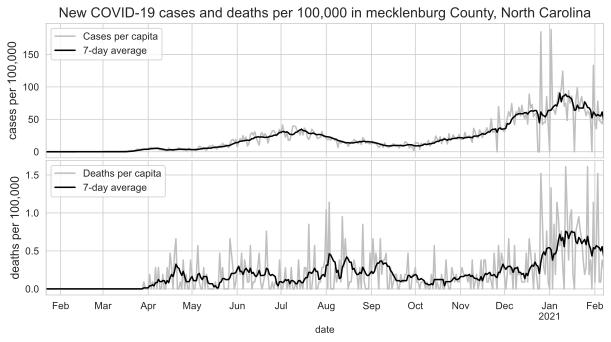

In [53]:
plot_cases(level="county", county="mecklenburg", state="North Carolina");

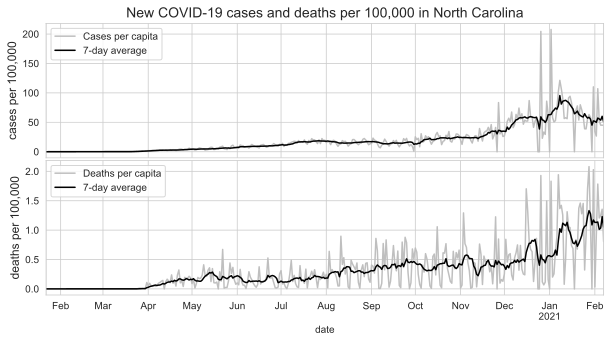

In [54]:
plot_cases(level="state", state="North Carolina");

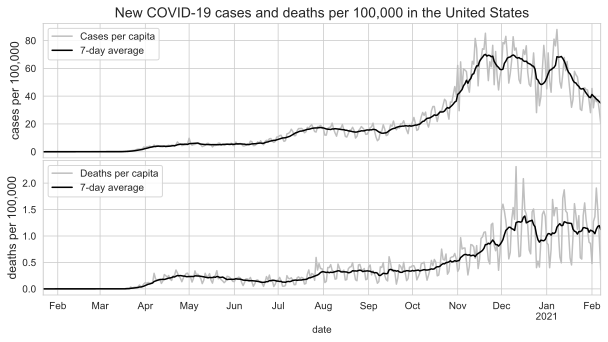

In [55]:
plot_cases(level="national");

## 2.2 <a id='2.2'>Policy data overlay</a>
[back to top](#top)<br>

Get policy data for a specific county at the state and county level, then overlay some selected policy enactments on top of the case / death figures

In [56]:
def get_policy_data(state="California", county="statewide", state_policies=True, county_policies=True, df=df2):
   
    """Get the policy data at county level, state level, or both.  

    Parameters
    ----------
    state : string 
        selected state
    county : string
        selected county
    state_policies : boolean 
        include policies at the state level (default: True)
    county_policies : boolean 
        include policies at the county level (default: True)
    
    Returns
    ---------- 
    filtered DataFrame
    """
    
    # state AND county policies
    if state_policies and county_policies:

        return df[(df['state'] == state) &
                  ((df["county"] == county) | (df["county"] == "statewide"))]
    
    # state policies only
    elif state_policies and not county_policies: 
        return df[ (df['state'] == state) & (df["county"] == "statewide")]
    
    # county policies only
    else:  
         return df[ (df['state'] == state) & (df["county"] == county)]

In [57]:
def plot_cases_and_policies(
        county, state, 
        colors=sns.color_palette()[:],
        policies=[
            "mandate face masks in public spaces", 
            "mandate face masks in businesses", 
            "shelter in place", 
            "state of emergency"],
                           
        labels=["face mask mandate (public spaces)", 
            "face mask mandate (businesses)", 
            "shelter in place", 
            "state of emergency"],
        save_figure=False, 
        filename="Plot cases and policies figure.png", 
        fig_size=(10, 5), 
        legend_position=(0, 0)
    ):

    
    """Plot the cases overlayed with the policies. 
    
    Parameters
    ---------- 
    county : string 
        county of interest
    state : string
        state of interest
    policies : array-like
        policies to plot (default: face mask mandates in public spaces and businesses, shelter in place, 
        and state of emergency)
    colors : array-like
        line colors for respective policies (in order) (default: k, b, r, g)
    labels : array-like 
        legend labels for the selected policies (default: "face mask mandate (public spaces)", 
        "face mask mandate (businesses)", "shelter in place", and "state of emergency")
    style : string 
        sns plot style (whitegrid by default, dark styles not recommended)
    fade : float
        level of transparency for new_cases_1e6 and new_deaths_1e6 (default: 0.75)
    
    The marks for policies are aligned with the 7 day average, using colors to indicate policy types, endcaps for 
    state (diamond) or county (circle), and linestyle to distinguish the start (solid line) or stop (dotted line) of a 
    policy. 
    
    Returns
    ----------
    ndarray containing the two axis handles used for plotting
    """

    
    # Plot case / death data.
    plt.figure();
    fig, ax, df = plot_cases(level="county", county=county, state=state, fig_size=fig_size);

    # Get the policy data for the selected state and county.
    policy_data = get_policy_data(state, county);

    # Set a solid line to be the start of a policy and a dashed line to be the end.
    styles_start_stop = {
        "start" : '-', 
        "stop" : ':'
    }

    # Set color codes for selected policies.
    styles_policy_type = {policies[i] : colors[i] for i in range(len(policies))}
    
    # Set labels for legend.
    legend_policy_labels = {policies[i] : labels[i] for i in range(len(policies))}
    
    # Define plot parameters.  
    line_split = 0                
    mark_length = 0.2
    plot_policies = policy_data[policy_data['policy_type'].isin(policies)]
    labels = []
    
    # Loop through both axes. 
    for i in range(2):
        
        # Expand y axis to get some extra room on the bottom.
        ax[i].set_ylim(-max(ax[i].lines[0].get_ydata())*(0.15))
        
        # Loop through policies.
        for index, row in plot_policies.sort_values(by="date").iterrows():

            # Get the y-positional coordinate for the line on the selected day (between 0 and 1). 
            if i == 0: 
                center = df[df.index == row.date]['new_cases_7day_1e6'].values[0]
            else: 
                center = df[df.index == row.date]['new_deaths_7day_1e6'].values[0]
            
            # Calculate where to position the line horizontally.  
            days_serial = (row.date - pd.Timestamp(year=1970, month=1, day=1)).days
            cent_coord = ax[i].transLimits.transform((days_serial, center))[1]

            # loop through all the policies enacted on a given day. Normally, this is 1, but we want to visualize all the
            # policies enacted on the same day, so we're goint to split the line accordingly.

            num_policies = plot_policies['date'].value_counts()[row.date]
            
            # Split the mark if there are multiple policies enacted on the same day.
            if num_policies > 1: 
                hmin = (cent_coord - (mark_length/2)) + line_split * (mark_length/num_policies)
                hmax = (cent_coord + (mark_length/2)) - \
                    (mark_length/num_policies) + ((line_split*mark_length) / num_policies)
                line_split += 1

            if num_policies == 1:
                hmin = (cent_coord - (mark_length/2))
                hmax = (cent_coord + (mark_length/2))
                line_split=0
                
            # Plot the mark.
            line = ax[i].axvline(x         = row.date,
                                 linestyle = styles_start_stop[row.start_stop], 
                                 color     = styles_policy_type[row.policy_type], 
                                 lw        = 2,
                                 ymin      = hmin, 
                                 ymax      = hmax,
                                )

            # Add the policy to the legend if it's not already in the list of labels
            if (row.policy_type not in labels): 
                labels.append(row.policy_type);
                
            # Set markers for state or county policies. 
            if row.policy_level == "state":
                line.set_marker('d')
                
            else: 
                line.set_marker('o')
                
            ax[i].legend(loc="upper left")
        
    # Make the legend. 
    legend_lines = []
    
    # Use square boxes to denote colors for policy types. 
    [legend_lines.append(Line2D([0], [0], marker="s", markersize=15, color='w', 
                           markerfacecolor=styles_policy_type[policy], lw=3, label=policy)) for policy in labels]
    
    # Draw a diamond to indicate a state policy. 
    legend_lines.append(Line2D([0], [0], marker="d", markersize=10, color='w', 
                           markerfacecolor='w', markeredgecolor='k', markeredgewidth=1.5, lw=3, label="state policy"))
    
    # Draw a circle to indicate a county policy. 
    legend_lines.append(Line2D([0], [0], marker="o", markersize=10, color='w', 
                           markerfacecolor='w', markeredgecolor='k', markeredgewidth=1.5, lw=3, label="county policy"))
    
    # Use a solid line for policy start, dotted line for policy stop. 
    legend_lines.append(Line2D([0], [0], linestyle='-', color='k', lw=3, label = "policy start"))
    legend_lines.append(Line2D([0], [0], linestyle=':', color='k', lw=3, label = "policy stop"))
                   
     
    # Finally, draw the legend. 
    leg1 = ax[0].legend(loc='upper left')
    leg2 = ax[0].legend(handles=legend_lines, loc='center',  bbox_to_anchor=legend_position, ncol=4)
    ax[0].add_artist(leg1);
    
    if save_figure: 
        plt.savefig(filename, bbox_inches='tight')
        
    return fig, ax

<Figure size 432x288 with 0 Axes>

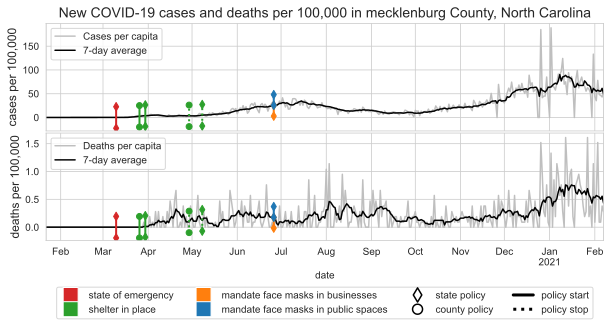

In [58]:
plot_cases_and_policies(county="mecklenburg", 
                        state="North Carolina", 
                        fig_size=(10, 4),
                        save_figure=True,
                        legend_position=(0.5, -1.6),
                        filename="Figures/cases_policies_meck_NC_282021.png");

# 3. <a id='corr'>Connecting case numbers and covid policies</a>
[back to top](#top)<br>

# 3.1 <a id='3.1'>Finding Correlations</a>
[back to top](#top)<br>

Find the correlation between case / death numbers and policies.

To do this, calculate two quantities related to the number of new cases and number of new deaths: <br>
1) (number of new cases / deaths  $x$ days after implementation - number of new cases / deaths on the day of implementation). This is will be called the case(death)\_$x$\_day\_delta<br>

2) (rate of change of new cases / deaths $x$ days after implementation $-$ rate of change of new cases / deaths on the day of implementation). This will be called the case(death)\_$x$\_day\_accel

In [41]:
def calculate_deltas(measure_period=14, filtered_policies=None, case_df=df, policy_df=df2, state_cases_dict=None): 
    """For every policy implementation at the state and county level, calculate the change in case and death numbers. 
    
    Parameters
    ---------- 
    measure_period : int
        time to wait (in days) before measuring a change in new case or death numbers (14 by default)
    filtered_policies : array-like 
        specify policies to select (defaul: None- calulate deltas for all policies)
    case_df : pandas DataFrame
        DataFrame with case / death information (default: df)
    policy_df : pandas DataFrame
        DataFrame with police information (default: df2)
    
    Returns
    ----------  
    A copy of the covid policies df (df2) with 2 appended columns for the change in case and death numbers. 
    """
    
    # Initialize wait period before measurement.
    wait_period = timedelta(days=measure_period)
    day_1 = timedelta(days=1)
    
    def sub_calc_deltas(ser, date, wait=wait_period): 
        """Wrap repeated calculations in a sub function to avoid repetition."""
        day_1 = timedelta(days=1)
    
        start      = ser[ser.index==date].values[0]
        start_1day = ser[ser.index==date+day_1].values[0]
        
        end        = ser[ser.index==date+wait].values[0]
        end_1day   = ser[ser.index==date+wait+day_1].values[0]
        
        return [start, start_1day, end, end_1day]
    
    # If there we are only examining select policies, then filter those out.
    if filtered_policies is not None: 
        policy_df = policy_df.loc[policy_df['policy_type'].isin(filtered_policies)]
        
    correlated_df = policy_df.copy()
    
    # Initially fill the delta column with nan.
    correlated_df.loc[:, f"case_{measure_period}_day_delta"] = np.nan
    correlated_df.loc[:, f"case_{measure_period}_day_accel"] = np.nan
    correlated_df.loc[:, f"death_{measure_period}_day_delta"] = np.nan
    correlated_df.loc[:, f"death_{measure_period}_day_accel"] = np.nan
    
    # Load all state-aggregated datasets into a dictionary. We expect to need all 50 states so let's take the time to aggregate
    # the state data now so we don't need to do it repeatedly in the loop. 
    
    if state_cases_dict is None: 
        state_cases_dict = dict()
        for state in [elem.name for elem in us.states.STATES]: 
            state_cases_dict[state]=get_cases(level="state", state=state);

    case_df = case_df.set_index('date')
    total_policies = len(policy_df)
    
    for index, data in policy_df.iterrows(): 
          
        # If this is a state-level policy, then we already have the DataFrame to use. 
        if data.policy_level == 'state': 
            state_df = state_cases_dict[data.state]
            ser_cases = state_df['new_cases_7day_1e6' ]
            ser_deaths = state_df['new_deaths_7day_1e6']
        
        # This must be a county level policy- filter the appropriate data. 
        else:
            ser_cases = case_df['new_cases_7day_1e6' ][case_df['fips_code'] == data.fips_code]
            ser_deaths = case_df['new_deaths_7day_1e6'][case_df['fips_code'] == data.fips_code]
        
        # Get the case and death numbers at the appropriate days. 
        c11, c12, c21, c22 = sub_calc_deltas(ser_cases, date=data.date)
        d11, d12, d21, d22 = sub_calc_deltas(ser_deaths, date=data.date)
           
        # Calculate the difference in new cases at the selected dates. 
        correlated_df.at[index, f"case_{measure_period}_day_delta"] = c21 - c11
        correlated_df.at[index, f"death_{measure_period}_day_delta"] = d21 - d11
        
        # Calculate the change in curvature (aka acceleration) of the case / death plots at policy implementation and
        # measure_period days afterwards. 
        
        correlated_df.at[index, f"case_{measure_period}_day_accel"] = ((c12-c11) - (c21-c22)) / measure_period
        correlated_df.at[index, f"death_{measure_period}_day_accel"] = ((d12-d11) - (d21-d22)) / measure_period    
    
    
    return correlated_df, state_cases_dict

In [42]:
print("Changes in cases / deaths 14 days after policy implementations:")
policy_deltas, state_cases_dict = calculate_deltas()
policy_deltas.head()

Changes in cases / deaths 14 days after policy implementations:


,state,county,fips_code,policy_level,date,policy_type,start_stop,comments,source,case_14_day_delta,case_14_day_accel,death_14_day_delta,death_14_day_accel
0,Mississippi,hinds,28049,county,2020-07-13,entertainment,start,Policy_Details: Executive Order by Governor Ta...,sip_submission_form: https://www.sos.ms.gov/co...,25.292215,-0.105470,-0.119947,0.038111
1,Arizona,statewide,4,state,2020-05-16,houses of worship,start,Policy_Details: All businesses are open but mu...,sip_submission_form: https://azgovernor.gov/si...,1.181946,0.023800,-0.004997,0.000156
2,Oregon,statewide,41,state,2020-05-15,non-essential businesses,start,Policy_Details: Currently open: Grocery stores...,sip_submission_form: https://govstatus.egov.co...,-0.152593,-0.002194,-0.021983,0.000098
5,Connecticut,statewide,9,state,2020-03-16,gyms,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,1.213029,0.016448,0.019440,0.001281
6,Michigan,statewide,26,state,2020-03-16,gyms,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,1.472359,0.019070,0.060381,0.001331


For every policy that was implemented more than 10 times, aggregate the 4 metrics to get the average (avg) and standard deviation (std). 

In [43]:
def calc_delta_stats(deltas, measure_period=14, min_samples=10):
    """Take the deltas calculated with each policy and calculate the average and sd. 
    Parameters
    ---------- 
    deltas : pandas DataFrame 
        dataframe of policy deltas on which to do the calculations
    measure_period : int 
        time to wait (in days) before measuring a change in new case or death numbers (14 by default)
    min_samples : int 
        minimum number of samples that a policy must have for reporting of average and std (default: 10)
    
    Returns
    ----------   
    A dataframe with a record for the start/stop of each policy type and the average / std of the change in 
    case / death numbers measure_period days after implementation
    """
    # Generate a new list of policy types differentiating between start and stop. 
    policy_types = ([elem + " - start" for elem in deltas['policy_type'].unique()]  
                    + [elem + " - stop"  for elem in deltas['policy_type'].unique()])
    
    # Initialize empty arrays for the associated statistics.
    case_avg, death_avg, case_std, death_std, num_samples = [], [], [], [], []
    case_accel_avg, death_accel_avg, case_accel_std, death_accel_std = [], [], [], []
    
    # Loop through all the policy types.
    for policy in policy_types:
        
        # Determine whether this policy is the beginning or end.  
        if policy.endswith("stop"):
            len_index = -7
            start_stop = "stop"
        else: 
            len_index = -8
            start_stop = "start"
        
        # Get arrays of all the deltas for each type of policy 
        case_data  = deltas[(deltas['policy_type'] == policy[:len_index]) & 
                            (deltas['start_stop'] == start_stop)][f'case_{measure_period}_day_delta']

        death_data = deltas[(deltas['policy_type'] == policy[:len_index]) & 
                            (deltas['start_stop'] == start_stop)][f'death_{measure_period}_day_delta']

        case_accel_data = deltas[(deltas['policy_type'] == policy[:len_index]) & 
                                 (deltas['start_stop'] == start_stop)][f'case_{measure_period}_day_accel']
         
        death_accel_data = deltas[(deltas['policy_type'] == policy[:len_index]) & 
                                  (deltas['start_stop'] == start_stop)][f'death_{measure_period}_day_accel']

        num_samples.append(len(case_data))
        
        # Calculate the averages and standard deviations for each policy
        case_avg.append(np.nanmean(case_data.to_numpy()))
        death_avg.append(np.nanmean(death_data.to_numpy()))
            
        case_std.append(np.nanstd(case_data.to_numpy()))
        death_std.append(np.nanstd(death_data.to_numpy()))
        
        case_accel_avg.append(np.nanmean(case_accel_data.to_numpy()))
        death_accel_avg.append(np.nanmean(death_accel_data.to_numpy()))
        
        case_accel_std.append(np.nanstd(case_accel_data.to_numpy()))
        death_accel_std.append(np.nanstd(death_accel_data.to_numpy()))
        
        
        
    # Construct the dataframe to tabulate the data.
    delta_stats = pd.DataFrame(np.transpose([case_avg, case_accel_avg, death_avg, death_accel_avg, 
                                             case_std, case_accel_std, death_std, death_accel_std, 
                                             num_samples]), index=policy_types, 
                               columns=['case_avg', 'case_accel_avg', 'death_avg', 'death_accel_avg', 
                                        'case_std', 'case_accel_std', 'death_std', 'death_accel_std', 
                                        'num_samples']
                              )

    # Drop record with less than min_samples samples.
    delta_stats.drop(delta_stats[delta_stats['num_samples'] <= min_samples].index, inplace=True)
    
    return delta_stats

In [44]:
delta_stats = calc_delta_stats(deltas = policy_deltas)
print("Changes in cases and deaths associated with policy implementations:")
delta_stats.head()

Changes in cases and deaths associated with policy implementations:


<ipython-input-43-715a146e52e3>:52: RuntimeWarning: Mean of empty slice
  case_avg.append(np.nanmean(case_data.to_numpy()))
<ipython-input-43-715a146e52e3>:53: RuntimeWarning: Mean of empty slice
  death_avg.append(np.nanmean(death_data.to_numpy()))
C:\Users\alexc\anaconda3\envs\covid_project\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-43-715a146e52e3>:58: RuntimeWarning: Mean of empty slice
  case_accel_avg.append(np.nanmean(case_accel_data.to_numpy()))
<ipython-input-43-715a146e52e3>:59: RuntimeWarning: Mean of empty slice
  death_accel_avg.append(np.nanmean(death_accel_data.to_numpy()))


,case_avg,case_accel_avg,death_avg,death_accel_avg,case_std,case_accel_std,death_std,death_accel_std,num_samples
entertainment - start,2.589929,-0.027899,-0.035841,-0.000898,11.818583,0.269728,0.475786,0.023427,149.0
houses of worship - start,3.430665,-0.076693,-0.040953,-0.002550,18.165869,0.415597,0.649061,0.035915,77.0
non-essential businesses - start,4.482265,0.067338,-0.058647,-0.000285,14.647177,0.587288,0.452990,0.021072,181.0
gyms - start,2.445999,0.023406,0.067237,0.000573,3.421345,0.068249,0.237476,0.002697,49.0
allow audio only telehealth - start,3.229401,0.020830,0.147806,0.001149,5.274714,0.051617,0.260551,0.003338,45.0


The "Mean of empty slice" warnings may be safely ignored. These correspond to policies that were never implemented. For example, many countries started 'allow audio only telehealth', but no county or state has stopped such a policy. 

## 3.2 <a id='3.2'>Evaluating Correlations</a>
[back to top](#top)<br>

Plot the 4 metrics as associated variances for each policy 7 days after a given policy implementation to evaluate how well this model performs. 

In [45]:
def eval_delta_stats(delta_stats, 
                     num_days=14, 
                     interval='std', 
                     save_figure=False, 
                     filename="eval delta stats figure.png"
                    ):
    
    """Evaluate the correlations between policy implementations and new cases / deaths. """
    
    # force interval to std 
    interval = 'std'
    fig, ax = plt.subplots(ncols=4, figsize=[10, 15], sharey=True)

    def eval_color(num, error): 
        if num+error<0: 
            return 'g'
        elif num-error>0: 
            return 'r'
        else: 
            return 'k'

    for i, index in enumerate(delta_stats.index): 
        vals     = delta_stats.loc[index][ :4].values
        vals_std = delta_stats.loc[index][4:-1].values
        n = delta_stats.loc[index][-1]

        for j, (val, val_std) in enumerate(zip(vals, vals_std)):  
    
            # if interval is 'std', set the errorbar to the same width as the std
            if interval == 'std': 
                err = val_std
            # if a confidence interval is specified, set error bar to with width of the desired CI
            else: 
                # Since the population variance is unkown, use the t-score (two-tail)
                # This method is still under development
                t = stats.t.ppf(1-(interval/2), n)
                err = (val + t*(val_std / math.sqrt(n)))
            
            ax[j].errorbar(y=i, 
                        x=val, 
                        xerr=err,
                        marker='.',
                        markersize=15,
                        capsize=5,
                        linewidth=3,
                        linestyle='None',
                        c=eval_color(val, err)
                       )
    titles = ["new cases", "acceleration of new cases", "new deaths", "acceleration of new deaths"]
    for i in range(4):
        lims = ax[i].get_ylim()
        ax[i].vlines(x=0, ymin=lims[0], ymax=lims[1], color='k')
        ax[i].set_ylim(lims)
        ax[i].set_title(titles[i])
        ax[i].tick_params(bottom=True, top=True, labelbottom=True, labeltop=True)
    plt.yticks(range(len(delta_stats.index)), delta_stats.index, fontsize=8)
    if interval == 'std':
        title = f"Correlations in covid policy metrics {num_days} days after implementation (errorbar = std)"
    else: 
        title = f"Correlations in covid policy metrics {num_days} days after implementation (CI = {interval})"
    plt.suptitle(title, y=0.95);
    
    if save_figure: 
        plt.savefig(filename)
    
    return fig

<ipython-input-43-715a146e52e3>:52: RuntimeWarning: Mean of empty slice
  case_avg.append(np.nanmean(case_data.to_numpy()))
<ipython-input-43-715a146e52e3>:53: RuntimeWarning: Mean of empty slice
  death_avg.append(np.nanmean(death_data.to_numpy()))
C:\Users\alexc\anaconda3\envs\covid_project\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-43-715a146e52e3>:58: RuntimeWarning: Mean of empty slice
  case_accel_avg.append(np.nanmean(case_accel_data.to_numpy()))
<ipython-input-43-715a146e52e3>:59: RuntimeWarning: Mean of empty slice
  death_accel_avg.append(np.nanmean(death_accel_data.to_numpy()))


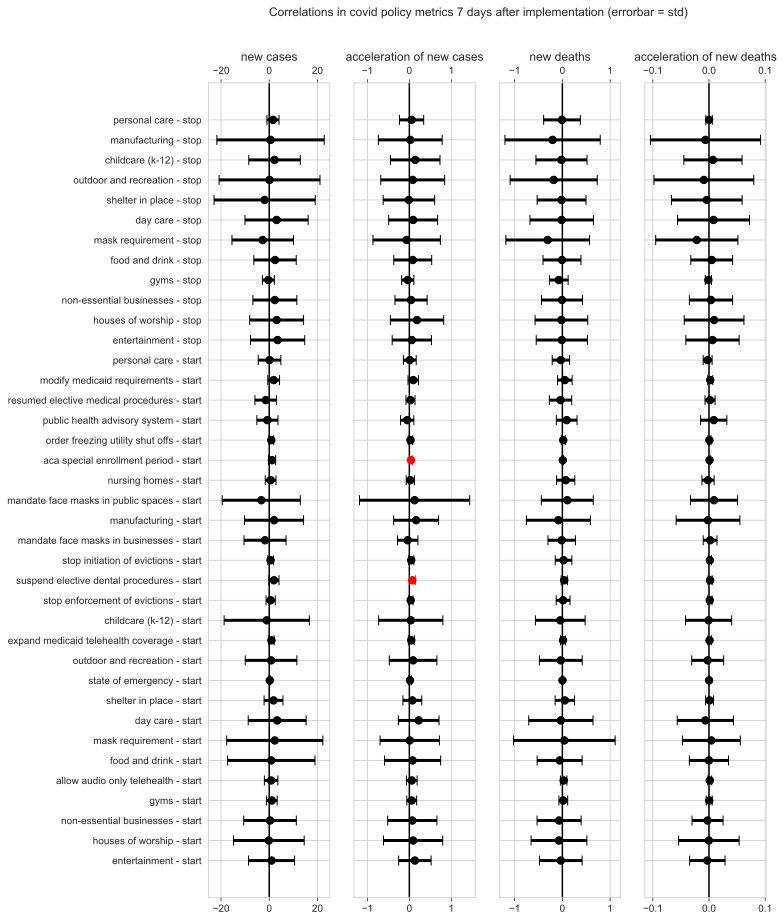

In [46]:
#days = [3, 7, 10, 14, 21]
days = [7]
state_cases_dict = None
for day in days: 
    deltas, state_cases_dict = calculate_deltas(measure_period=day, state_cases_dict=state_cases_dict)
    
    eval_delta_stats(calc_delta_stats(deltas=deltas, measure_period=day), 
                     num_days=day)

Many of these policies don't definitively correlate to an increase or decrease in case / death numbers, except for acceleration in new cases with 'aca special enrollment period - start' and 'suspend elective dental procedures - start'

It is difficult to judge the actual impacts that these policies had based on these visualizations, since these case and death numbers were influenced by a large number of variables, most notably other policy implementations, but also other environmental and societal factors. 

To better quantify how these policies may have impacted the number of cases and deaths, it is necessary to uncouple multiple policy implementations, which calls for a regression algorithm. 

# 4 <a id='4'>Regression Modeling</a>
[back to top](#top)<br>

Create a regression model to estimate the number of new cases / deaths given a set of policy implementations. 

## 4.1 <a id='4.1'>Preprocessing</a>
[back to top](#top)<br>

Further process policy data for the model:
- Some policies are very similar, so use a dictionary to group these together and simplify the model. 
- define a new field encoding policy type, level, and whether it was the start or stop of a policy
- Remove policies that were implemented less than 10 times. 

In [47]:
policy_dict = {
    'aca special enrollment period' : 'medical', 
    'agriculture' : 'agriculture',
    'allow audio only telehealth' : 'medical', 
    'alternative care facilities' : 'medical', 
    'bars' : 'entertainement', 
    'childcare (k-12)' : 'childcare', 
    'colleges & universities' : 'education',
    'construction' : 'construction', 
    'day camps/overnight camps' : 'camps', 
    'day care' : 'childcare',
    'education' : 'education', 
    'election' : 'election', 
    'entertainment' : 'entertainment', 
    'executive order' : 'executive order',
    'expand medicaid telehealth coverage' : 'medical', 
    'food and drink' : 'entertainment',
    'froze mortgage payments' : 'housing', 
    'gatherings' : 'gatherings', 
    'grace period / security deposit for rent' : 'housing', 
    'graduation' : 'graduation',
    'graduation ceremony guidelines' : 'graduation', 
    'gyms' : 'gyms', 
    'health risk status' : 'medical',
    'higher education' : 'education', 
    'houses of worship' : 'houses of worship', 
    'libraries' : 'education',
    'mandate face masks in businesses' : 'mask mandate',
    'mandate face masks in public spaces' : 'mask mandate', 
    'manufacturing' : 'manufacturing',
    'mask requirement' : 'mask mandate', 
    'medical' : 'medical', 
    'modify medicaid requirements' : 'medical',
    'museums' : 'education', 
    'non-essential businesses' : 'non-essential businesses', 
    'nursing home visitations' : 'nursing homes',
    'nursing homes' : 'nursing homes', 
    'order freezing utility shut offs' : 'housing',
    'outdoor and recreation' : 'outdoor and recreation', 
    'personal care' : 'personal care', 
    'public gatherings' : 'gatherings',
    'public health advisory system' : 'medical', 
    'quarantine' : 'shelter in place',
    'residential overnight camps' : 'camps',
    'resumed elective medical procedures' : 'medical', 
    'shelter in place' : 'shelter in place',
    'state of emergency' : 'state of emergency', 
    'state of emergency/funds' : 'state of emergency',
    'stop enforcement of evictions' : 'housing', 
    'stop initiation of evictions' : 'housing',
    'suspend elective dental procedures' : 'medical', 
    'training jobs' : 'training jobs', 
    'travel' : 'travel',
    'traveler from out of state' : 'travel', 
    'updated guidelines' : 'updated guidelines',
    'wholesale trade' : 'wholesale trade',
}

In [48]:
def prep_policy_data(df2, policy_dict=policy_dict, min_samples=10):
    """Small funciton to process policy data
    df2: DataFrame with the policy data
    policy_dict: dictionary to rename / aggregate policy types
    min_samples: throw out policies that were not implemented many times
    """
    
    proc_policy_data = df2.copy()
    
    # Replace policies with the ones in policy_dict(). 
    for key in policy_dict.keys():
        proc_policy_data['policy_type'].replace(to_replace=key, value=policy_dict[key], inplace=True)
        
    # Define a new field that includes policy_type, start_stop, and policy_level information
    proc_policy_data.loc[:, 'full_policy'] = proc_policy_data['policy_type'] + " - " +\
                                        proc_policy_data['start_stop'] + " - " +\
                                        proc_policy_data['policy_level']
    
    # Get number of times each policy was implemented.
    num_samples = proc_policy_data['full_policy'].value_counts()
    
    # drop the policy if it was implemented fewer than min_policy times. 
    proc_policy_data = proc_policy_data.drop(proc_policy_data[
        proc_policy_data['full_policy'].isin(num_samples[num_samples.values < min_samples].index)
    ].index)
    
    # return the DataFrame
    return proc_policy_data

df2_updated = prep_policy_data(df2)
print("df2 processed")
df2_updated.head()

df2 processed


,state,county,fips_code,policy_level,date,policy_type,start_stop,comments,source,full_policy
0,Mississippi,hinds,28049,county,2020-07-13,entertainment,start,Policy_Details: Executive Order by Governor Ta...,sip_submission_form: https://www.sos.ms.gov/co...,entertainment - start - county
1,Arizona,statewide,4,state,2020-05-16,houses of worship,start,Policy_Details: All businesses are open but mu...,sip_submission_form: https://azgovernor.gov/si...,houses of worship - start - state
2,Oregon,statewide,41,state,2020-05-15,non-essential businesses,start,Policy_Details: Currently open: Grocery stores...,sip_submission_form: https://govstatus.egov.co...,non-essential businesses - start - state
5,Connecticut,statewide,9,state,2020-03-16,gyms,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,gyms - start - state
6,Michigan,statewide,26,state,2020-03-16,gyms,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,gyms - start - state


**Primary data preprocessing function:** 

This function will join the policy dataset and case / death dataset. The policies will be organized into `bins` - date ranges specifying the time since the given policy implementation.

The dataframe will have the following form: 
    
| info<br>state |  <br>county  | <br>date | <br>num_new_cases | policy name<br>[date range 1]| <br>[date range 2] | <br> [date range 3]|
| ------------- | ------------ | -------  | ----------------- | ------ | ------ | ------ |
| state name    | county name  |   date   | # of new cases    | 0 or 1 | 0 or 1 | 0 or 1 |

In the columns labeled '0 or 1': <br>
1 if the policy was implemented within the selected date range, 0 otherwise.<br> 
Date range 1 will always start at 0 days.<br>
Date range 3 (or the final date range) will always end in 999 (this bin extends all the way to the current day)

Simple example: 

| info<br>state |  <br>county  | <br>date | <br>num_new_cases | policy name<br>0-2| <br>3-5 | <br>6-999|
| ------------- | ------------ | -------  | ----------------- | ------ | ------ | ------ |
| state   | county  | date - 1 | # of new cases | 0 | 0 | 0 |
| state   | county  | policy enacted today | # of new cases | 1 | 0 | 0 |
| state   | county  | date + 1 | # of new cases | 1 | 0 | 0 |
| state   | county  | date + 2 | # of new cases | 1 | 0 | 0 |
| state   | county  | date + 3 | # of new cases | 0 | 1 | 0 |
| state   | county  | date + 4 | # of new cases | 0 | 1 | 0 |
| state   | county  | date + 5 | # of new cases | 0 | 1 | 0 |
| state   | county  | date + 6 | # of new cases | 0 | 0 | 1 |
| state   | county  | date + 7 | # of new cases | 0 | 0 | 1 |
| state   | county  | date + 8 | # of new cases | 0 | 0 | 1 |
|    |   | ... |  |  |  | |
| state   | county  | today | # of new cases | 0 | 0 | 1 |


The number of bins and bin sizes will be optimized to get the least error from the model. 

In [49]:
def process_data(case_df, policy_df, output, bins_list=[(0, 6), (7, 13), (14, 999)], state_output=False):
    """Date preprocessing function. 
    
    This function works by generating a processed DataFrame for each state and the concatenating the resulting 
    50 DataFrames at the very end.
    
    Parameters
    ------------
    case_df: DataFrame
        case data
    policy_df: DataFrame
        policy data
    output: boolean
        output time elapsed after running 
    bins_list: list
        list of tuples with the desired date ranges
        default: [(0, 6), (7, 13), (14, 999)]
    state_output: boolean
        output time elapsed for filtering with each state
        default: False
    
    Returns
    ------------
    Processed DataFrame
    
    """
    time_start = time.time()
    
    # Define a sub-function to convert passed integers to the desired date range starting from a given date.
    def get_date_range(date, start_move=0, stop_move=7): 
        """Get the date range from date+start_move to date+stop_move"""
        
        return pd.date_range(start=date+timedelta(days=start_move), 
                             end=date+timedelta(days=stop_move))
        
    # Make list of all policies.
    all_policies = policy_df['full_policy'].unique()
    
    # Construct multiIndex for df3.
    tuples_info = [("info", "state"), ("info", "county"), ("info", "date"), ("info", "new_cases_1e6")]

    tuples_policies = [ (policy, (str(date_range[0]) + "-" + str(date_range[1]))) 
                       for policy in all_policies for date_range in bins_list]
    
    tuples_index = tuples_info + tuples_policies
    col_index = pd.MultiIndex.from_tuples(tuples_index)
        
    # Get list of all states.
    all_states = case_df['state'].unique()
    
    # Generate a list of empty dataframes- one for each state.
    frames = [pd.DataFrame() for state in all_states]
    
    # Loop through all states.
    for (i, state) in enumerate(all_states):
        
        if output: 
            state_time_start = time.time()
            
        # Initiallize dataFrame.
        frames[i] = pd.DataFrame(columns = pd.MultiIndex.from_tuples(tuples_info + tuples_policies), data = {
            ("info", "state")         : state, 
            ("info", "county")        : case_df['county'][case_df['state']==state], 
            ("info", "date")          : case_df['date'][case_df['state']==state], 
            ("info", "new_cases_1e6") : case_df['new_cases_1e6'][case_df['state']==state]
        })
        
        # Filter policy data to only those that were enacted in that state.
        filtered_policy = policy_df[policy_df['state']==state]
        
        # Loop through every policy that was implemented in the current state.
        for (date, county, policy, level) in zip(filtered_policy['date'], 
                                                 filtered_policy['county'],
                                                 filtered_policy['full_policy'], 
                                                 filtered_policy['policy_level']):
            # Loop through each bin
            for date_bin in bins_list:
                
                # calculate the date range
                date_range = get_date_range(date, date_bin[0], date_bin[1])
                
                # Generate label (this is the 2nd level label in the multiIndexed column)
                label = (str(date_bin[0]) + "-" + str(date_bin[1]))
                
                # For every record in frames that falls within the date range of the specific policy, 
                # set the appropriate column to 1. 
                frames[i].loc[(
                    (frames[i]['info', 'date'].isin(date_range)) &\
                    ((frames[i]['info', 'county'] == county) | (level == 'state')) &\
                    (frames[i]['info', 'state'] == state)), (policy, label)] = 1
        
        if state_output: 
            state_time_end = time.time()
            print(f"{state}: {state_time_end - state_time_start} seconds")
    
    # Concat the DataFrames
    df3 = pd.concat([frames[i] for i in range(len(frames))])
    
    # Fill NaNs
    df3.fillna(0, inplace=True)
    time_end = time.time()
    
    if output: 
        print(f"data shaped\nbins: {bins_list}\ntime elapsed: {time_end - time_start}")
        
    return df3

In [50]:
print("testing data preprocessing")
df3 = process_data(case_df = df, policy_df = df2_updated.copy(), output=True);

testing data preprocessing
data shaped
bins: [(0, 6), (7, 13), (14, 999)]
time elapsed: 89.3723828792572


Filter df3 to a random policy implementation to check verify all calculations executed correctly.

In [51]:
# Select a random policy
rand_index = random.randint(0, len(df2_updated)-1)
rand_policy = df2_updated.iloc[rand_index]

print("Randomly selected policy:\n ")
print(df2_updated.iloc[rand_index])

# If this is a statewide policy, select a random county from that state
if rand_policy.county == 'statewide': 
    county = random.choice(df3['info', 'county'][df3['info', 'state'] == rand_policy.state].unique())
else: 
    county = rand_policy.county

print("\nAssociated DataFrame slice:\n ")

# Show a slice of the processed DataFrame with the chosen policy and location. 
df3.loc[(df3['info', 'date'] >= rand_policy.date - timedelta(days=1)) &\
        (df3['info', 'county'] == county) &\
        (df3['info', 'state'] == rand_policy.state), 
        [('info', 'date'), 
         ('info', 'county'),
         ('info', 'state'),
         (rand_policy.full_policy, '0-6'), 
         (rand_policy.full_policy, '7-13'), 
         (rand_policy.full_policy, '14-999')]].head(20)

Randomly selected policy:
 
state                                                    Colorado
county                                                  statewide
fips_code                                                       8
policy_level                                                state
date                                          2020-04-26 00:00:00
policy_type                                      shelter in place
start_stop                                                   stop
comments        Stay at home, effective 6:00 a.m. MDT, March 2...
source                                                     manual
full_policy                       shelter in place - stop - state
Name: 3302, dtype: object

Associated DataFrame slice:
 


info                   shelter in place - stop - state       \
             date  county     state                             0-6 7-13   
133378 2020-04-25  gilpin  Colorado                               0    0   
133379 2020-04-26  gilpin  Colorado                               1    0   
133380 2020-04-27  gilpin  Colorado                               1    0   
133381 2020-04-28  gilpin  Colorado                               1    0   
133382 2020-04-29  gilpin  Colorado                               1    0   
133383 2020-04-30  gilpin  Colorado                               1    0   
133384 2020-05-01  gilpin  Colorado                               1    0   
133385 2020-05-02  gilpin  Colorado                               1    0   
133386 2020-05-03  gilpin  Colorado                               0    1   
133387 2020-05-04  gilpin  Colorado                               0    1   
133388 2020-05-05  gilpin  Colorado                               0    1   
133389 2020-05-06  gilpin  Colorado                               0    1   
133390 2020-05-07  gilpin  Colorado                               0    1   
133391 2020-05-08  gilpin  Colorado                               0    1   
133392 2020-05-09  gilpin  Colorado                               0    1   
133393 2020-05-10  gilpin  Colorado                               0    0   
133394 2020-05-11  gilpin  Colorado                               0    0   
133395 2020-05-12  gilpin  Colorado                               0    0   
133396 2020-05-13  gilpin  Colorado                               0    0   
133397 2020-05-14  gilpin  Colorado                               0    0   

               
       14-999  
133378      0  
133379      0  
133380      0  
133381      0  
133382      0  
133383      0  
133384      0  
133385      0  
133386      0  
133387      0  
133388      0  
133389      0  
133390      0  
133391      0  
133392      0  
133393      1  
133394      1  
133395      1  
133396      1  
133397      1

In some cases, it appears that the same policy was implemented twice. This is likely due to the fact that similar policies were grouped together

The table below illustrates what I'm talking about. In this example, A policy was implemented on day 2 and a similar policy type was implemented on day 6. 

 | date | bin1 | bin2 |
 | ---- | ---- | ---- |
 | day 1| 0 | 0 |
 | day 2| 1 | 0 |
 | day 3| 1 | 0 |
 | day 4| 0 | 1 |
 | day 5| 0 | 1 |
 | day 6| 1 | 1 |
 | day 7| 1 | 1 |
 | day 8| 0 | 1 |
 
This is currently of no serious concern, but may need to be referenced in future iterations of this project in case any issues arise. 

## 4.2 <a id='4.2'>Test Model</a>
[back to top](#top)<br>

Fit an ordinary least-squares model and check for sensible results. 

In [52]:
X = df3.loc[:, df3.columns[4:]].values
y = df3.loc[:, ('info', 'new_cases_1e6')].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.005)
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

Implement a function to evaluate model performance by plotting the coefficients of each policy at each time period of interest. The plotting functionality only works with algorithms that have an .coef_ attribute. 

R score: 0.07726673213057911
regression coefficients:
[ 18.20318024  16.09611604  -1.09433413  -6.6727557   -7.27120927
  -0.41408162  -6.03862248  -5.22231556  -3.23753129  -1.90521134
  -1.80769329  -3.17761919  -2.4064579   -2.3456071    6.62914442
  -6.66710521  -5.8121106   -2.27874361  -0.99970249  -2.10262674
   6.96138101  -3.55701763  -5.06325729  -5.78676388   1.77290816
   6.87435199  13.10568499 -11.98764566  -9.87518792  -2.30273639
  -2.67792733  -3.92683208   2.42150981   1.88942349   1.78560878
  -3.06739229  -9.67003126  -9.64098546   0.82406128   5.44802616
   7.40996029  14.915713    -1.6503126   -1.39128734  -6.19893275
   2.85738115   1.65009817   7.15781734  -0.40354087   0.71392064
   1.34158136   4.96210504   2.49973782  -0.29538887  -3.70103339
  -4.59300079  -2.07817056 -16.34010582 -20.46224559   4.76956895
   0.8002906    3.68210406   1.29382007   3.19559916   2.68199418
   0.57887962   4.9335342    7.36069697  -2.63497019  -5.17928096
  -3.77496884  -7.5327

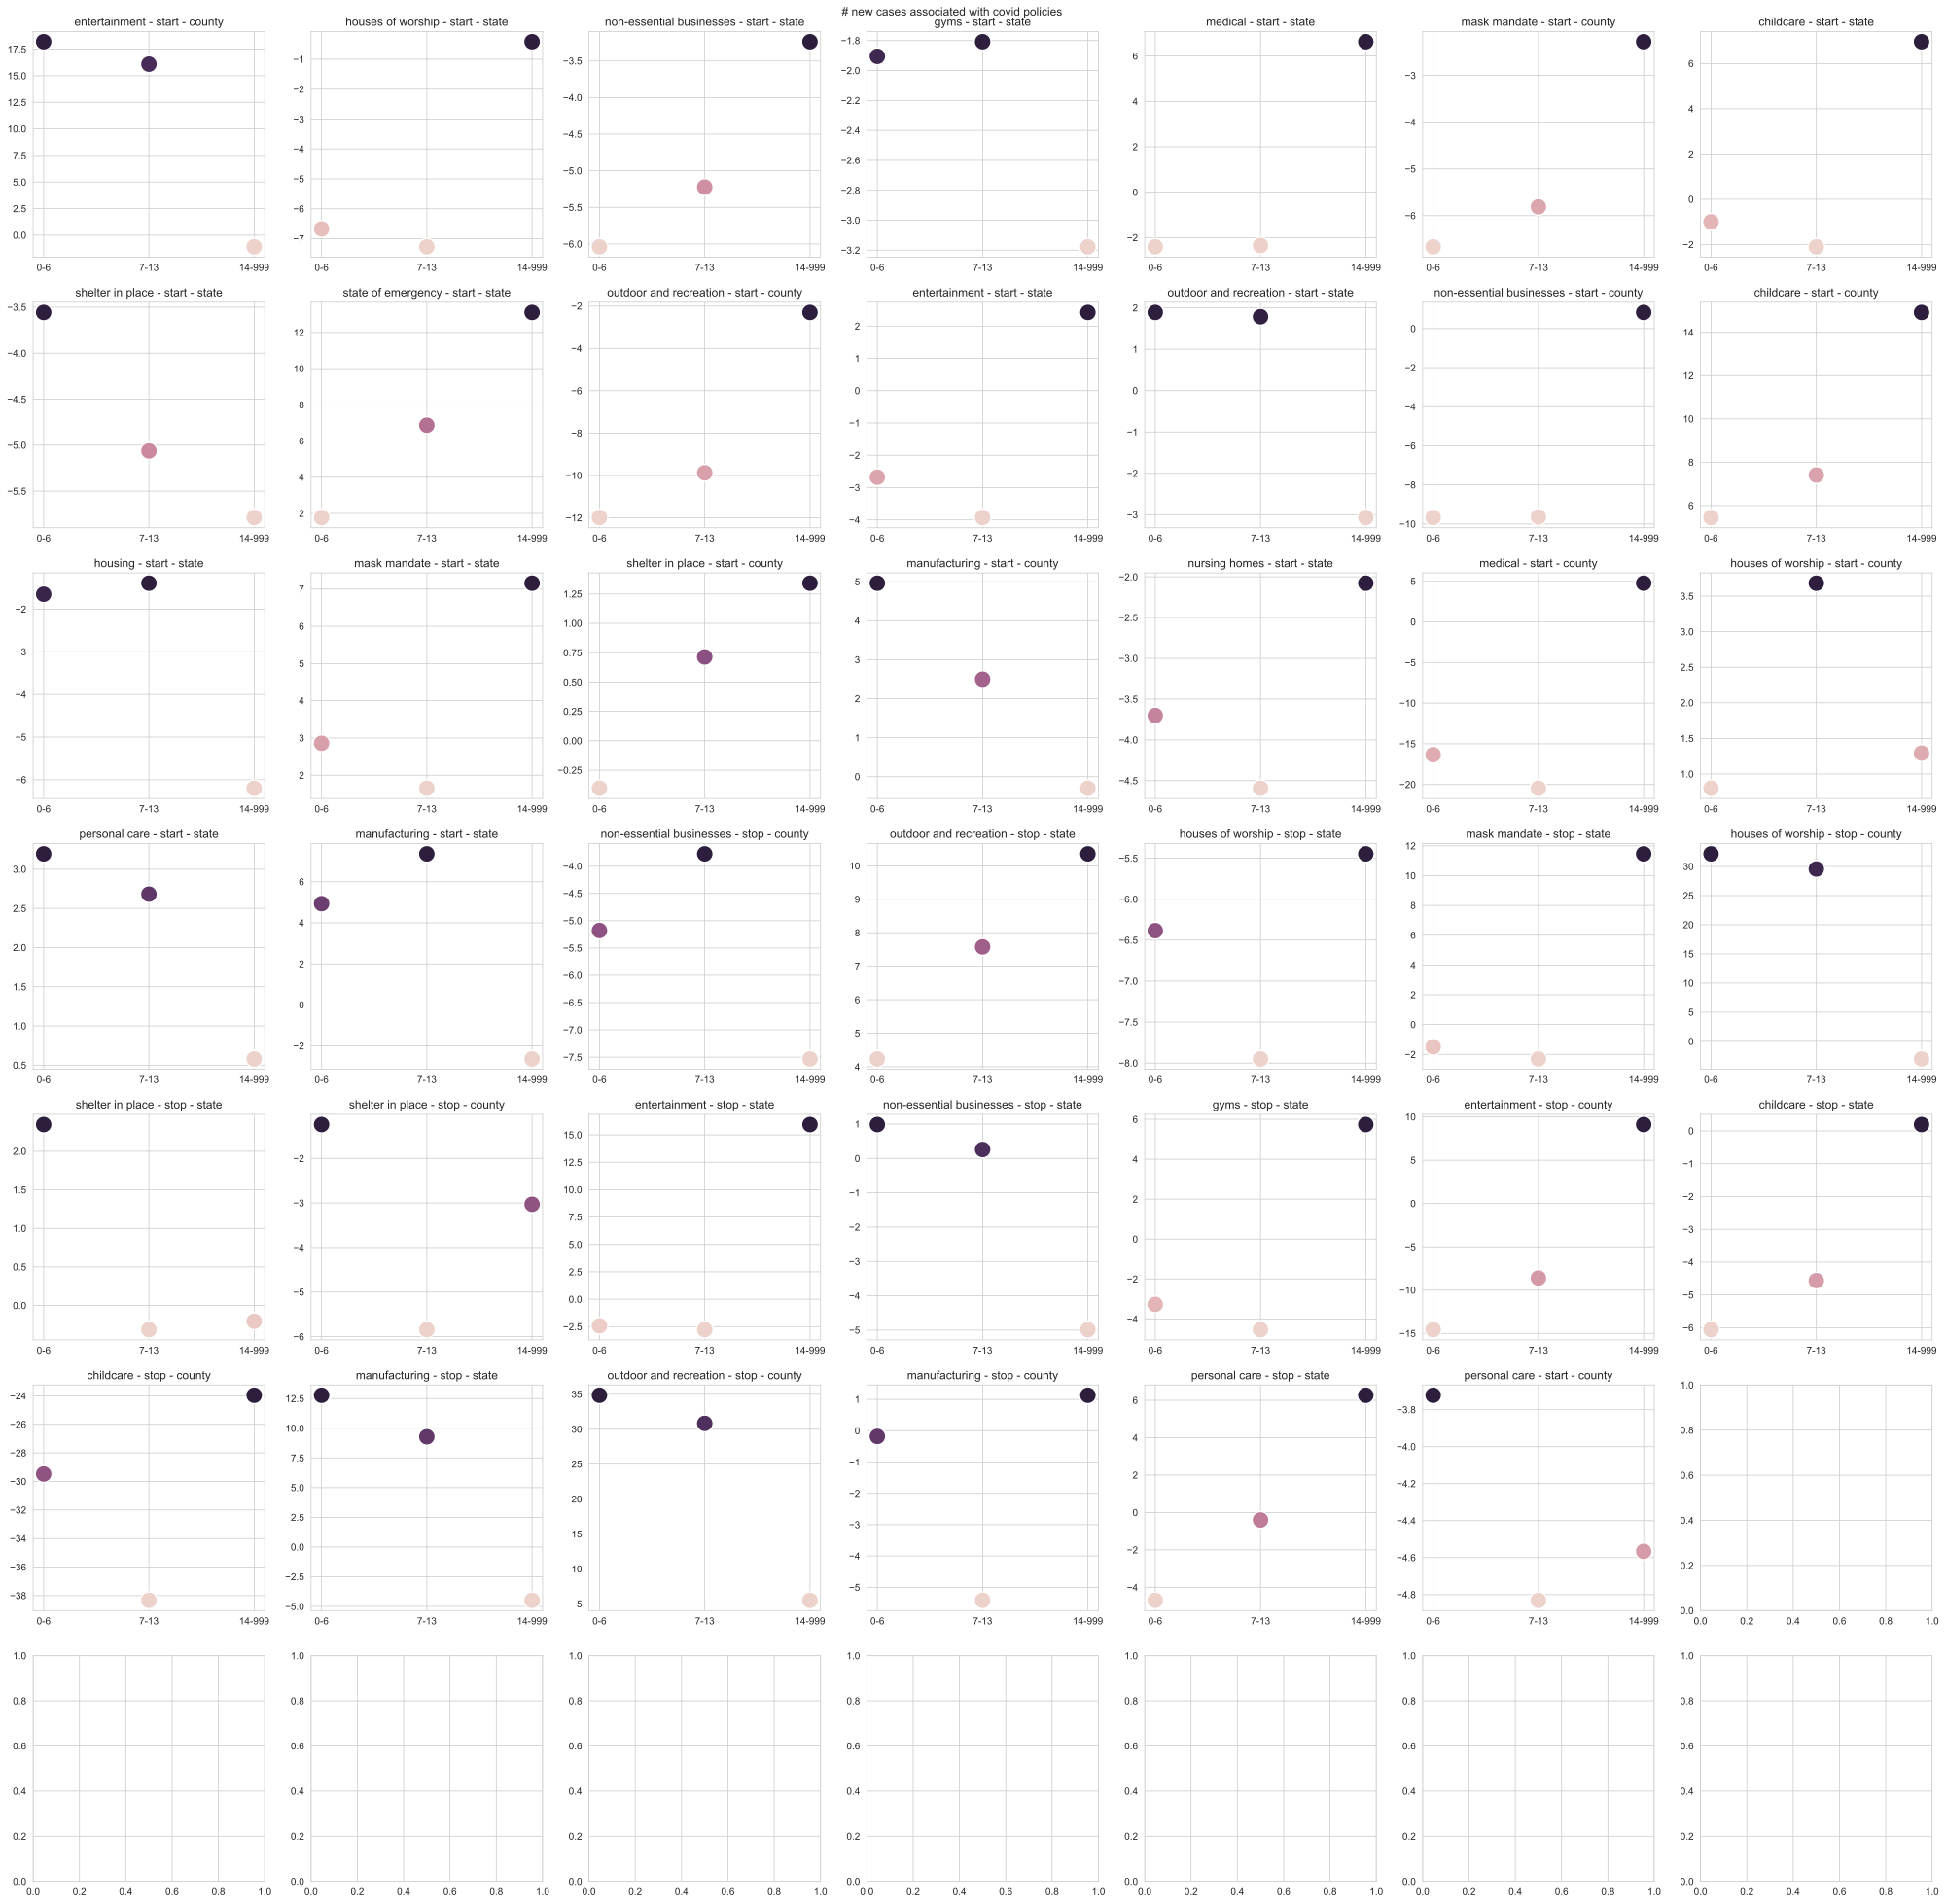

In [53]:
def eval_model(regressor, df3, print_coefs=False, plot_results=False, X_test=X_test, y_test=y_test):
    coefficients = regressor.coef_
    if print_coefs: 
        print(f"R score: {regressor.score(X_test, y_test)}")
        print(f"regression coefficients:")
        print(coefficients)
    
    results = pd.DataFrame(index=df3.columns[4:], data={"coefficient": coefficients})
    results = results.unstack()
    
    if plot_results: 
        # plot the relative magnitudes of the weights for each policy
        side_size = int(np.ceil(math.sqrt(len(results.index))))

        fig, ax = plt.subplots(nrows=side_size, ncols=side_size, figsize=[side_size*5, side_size*5])

        i = j = 0 # j = column, i = row
        x = [elem [1] for elem in results.columns.tolist()]

        for index in results.index: 
            if j == side_size: 
                j = 0
                i += 1
            g = sns.scatterplot(x=x, 
                            y=results.loc[index].values, 
                            ax=ax[i][j],
                            s=300, 
                            hue=results.loc[index].values)
            g.legend_.remove()
            ax[i][j].set_title(index)
            j+=1

        fig.suptitle("# new cases associated with covid policies", y=0.89);
    return results, coefficients

results, coefficients = eval_model(regressor, df3, print_coefs=True, plot_results=True)

This model has a very low R-squared, so there is much improvement to be had. However, the coefficients appear to be taking on reasonable values, suggesting that the data has been processed appropriately. In the next section, I will experiment with different regression models and bin sizes to find a candidate for the model. 

## 4.3 <a id='4.3'>Model Selection & Feature Engineering</a>
[back to top](#top)<br>
Systematically work through a series of bin selections and regression models to identify hopeful candidates. Save the R squared values in a csv file (this process is expected to take a long time).

Declare a dictionary of bins to try. For easier analysis, each bin is being assigned a unique id. 

In [54]:
bins_dict = {
    
    # 2 bins
    0: [(0, 10), (11, 999)],
    1: [(0, 50), (51, 999)], 
    2: [(0, 100), (101, 999)], 
    
    # 3 bins
    3: [(0, 3), (4, 10), (11, 999)], 
    4: [(0, 3), (4, 20), (21, 999)], 
    5: [(0, 3), (4, 50), (51, 999)], 
    6: [(0, 10), (11, 20), (21, 999)], 
    7: [(0, 10), (11, 40), (41, 999)], 
    8: [(0, 10), (11, 60), (61, 999)],
    9: [(0, 20), (21, 40), (41, 999)],
    10: [(0, 20), (21, 60), (61, 999)],
    11: [(0, 20), (21, 100), (101, 999)],
    
    # some other bin distributions
    12: [(0, 10), (11, 20), (21, 30), (31, 40), (41, 50), (51, 999)],
    13: [(0, 10), (11, 30), (31, 60), (61, 100), (101, 150), (151, 210), (211, 999)],
    14: [(0, 20), (21, 40), (41, 60), (61, 100), (101, 140), (141, 200), (201, 999)],
    
    # bin distributions from an old version (commented for posterity)
    #[(0, 3), (4, 10), (11, 30), (31, 999)],
    #[(0, 10), (11, 20), (21, 30), (31, 50), (51, 100), (101, 999)], 
    #[(0, 3),  (4, 10), (11, 20), (21, 40), (41, 70), (71, 100), (101, 999)]
}

print("bins dictionary initialized")
print(f"bin 0: {bins_dict[0]}")
print(f"bin 14: {bins_dict[14]}")

bins dictionary initialized
bin 0: [(0, 10), (11, 999)]
bin 14: [(0, 20), (21, 40), (41, 60), (61, 100), (101, 140), (141, 200), (201, 999)]


Write a function that automatically tests different regression models for each bin the dictionary defined above. The current models being implemented are: [Ordinary least squares](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), [Ridge regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html), [Elastic Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html), [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html), and [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) (with 10 estimators as default). 

Note: [Suppport Vector Regression](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) was attempted, but this algorithm was rejected for inefficiency. 

In [55]:
def train_models(bins_dict, 
                 test_size=0.1, 
                 algorithms={'OLS': LinearRegression()}, 
                 num_trees=10,
                 params_txt="All default",
                 comments = "",
                 verbose=True, 
                 save_output=True):
    
    """Combined feature engineering and model selection. 
    
    For list of bins in bins_dict, train various regression models and output the associated R squared. 
    Note that this function does not return the regressor objects themselves, only R squared values
    
    Parameters
    ------------
    bins_dict: dictionary 
        key: bin id, values: list of date ranges to use
    test_size: float
        argument for train_test split. default: 0.1
    algorithms: dictionary
        keys: algorithm abbreviation, values: call to constructor method for selected algorithm
        default: {'OLS': LinearRegression()} - only run ordinary least squares regression
    params_text: string
        description of parameters (will be written to log file)
    comments: string
        additional comments (will be written to log file)
    verbose: boolean
        output updates during function call. default: True
    save_output: boolean
        save R squared results as a CSV file. default: True
        
    Returns
    ------------
    DataFrame of least-squares regression results for each algorithm and selected date ranges
    
    """
    
    total_start = time.time()
    
    #### Configure file outputs. #### 
    
    # Make string of all bins used in this run
    bins_str =  ""
    for i in bins_dict: 
        bins_str += f"{bins_dict[i]} \n"
        
    # Generate header text for log file.
    results_description = dedent(f"""
    algorithms: {list(algorithms.keys())}
    parameters: {params_txt}
    training test size: {test_size}
    data: R squared values
    
    all bins: 
    {bins_str}
    
    Comments: {comments}\n
    ======================================\n
    """)
    
    # Generate tag based on current time for unique file names. 
    time_tag = time.strftime('%Y%m%d-%H%M%S')
    
    # Write to log file. 
    name = f"model_selection_results/log {time_tag}.txt"
    with open(name, "w") as log: 
        log.write(results_description)
            
    #### Model selection ####
    
    # rows_list is a list of dictionaries with values for each row to build the results dataframe.
    rows_list = []
    results = pd.DataFrame()
    
    # Loop through all the date ranges passed in bins_dict.
    for i in range(len(bins_dict)): 
        
        # Initialize dictionary, bin_id, and the list of date ranges to use while preprocessing data 
        dict1 = {}
        dict1['bin_id'] = i
        bins_list = bins_dict[i]

        #### Data Preprocessing ####
        
        # Output to log. 
        print("prepping data")
        with open(name, "a") as log: 
            log.write("prepping data\n")
            
        time_prep_start = time.time()
        
        # Now that the list of date ranges is selected, run process_data() to configure the independent variables.
        df_prepped = process_data(case_df=df, 
                                  policy_df=df2_updated.copy(), 
                                  output=verbose, 
                                  bins_list=bins_list)
        
        time_prep_end = time.time()
        
        # Output to log.
        if verbose: 
            print("----------------------------------------")
        with open(name, "a") as log: 
            log.write(f"data prepped\nbins: {bins_list}\ntime elapsed: {time_prep_end - time_prep_start}")
            log.write("\n----------------------------------------\n")
            
        # Split independent and dependent variables, split into training and test set. 
        X = df_prepped.loc[:, df_prepped.columns[4:]].values
        y = df_prepped.loc[:, ('info', 'new_cases_1e6')].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        
        # Loop through each algorithm.
        for alg in algorithms.keys(): 
            
            # Logging
            time_start = time.time()
            with open(name, "a") as log: 
                if alg == 'RF': 
                    log.write(f"training {alg}, num_trees = {num_trees}\n")
                else: 
                    log.write(f"training {alg}\n")
            
            if verbose: 
                print(f"training {alg}")
                
            # Build regressor and fit.
            regressor = algorithms[alg]
            regressor.fit(X_train, y_train)
            
            # Calculate R squared value.
            R_square = regressor.score(X_test, y_test)
            dict1[alg] = R_square
            
            # Logging
            time_end = time.time()
            time_elapsed = time_end - time_start
            if verbose: 
                print(f"done; time elapsed: {time_elapsed}")
            with open(name, "a") as log: 
                log.write(f"time elapsed: {time_elapsed}; R^2 = {R_square}\n")
                log.write(str(regressor.get_params()))
                log.write(f"\n{alg} done \n\n\n\n")

        # Even more logging
        if verbose: 
            print("==========================================")
        rows_list.append(dict1)
        with open(name, "a") as log: 
                log.write("\n==========================================\n")
    
    # Generate DataFrame of results
    results = pd.DataFrame(rows_list)
    
    # Tired of logging yet? 
    if save_output: 
        results.to_csv(f"model_selection_results/regression results {time_tag}.csv")
    
    total_end = time.time()
    with open(name, "a") as log: 
        log.write(f"\nDone!\ntime elapsed: {total_end - total_start}")
    print(f"Done! time elapsed: {total_end-total_start}")
    
    # Return the DataFrame of results
    return results

In [59]:
print("Testing train_models with one algorithm and one set of bins:\n\n")
test = train_models(bins_dict={0: [(0, 50), (51, 999)]}, 
                    algorithms={'Least Squares': LinearRegression()}, 
                    verbose=True, 
                    save_output=False)

Testing train_models with one algorithm and one set of bins:


prepping data
data shaped
bins: [(0, 50), (51, 999)]
time elapsed: 74.82068109512329
----------------------------------------
training Least Squares
done; time elapsed: 5.9776506423950195
Done! time elapsed: 84.72301411628723


In [60]:
print("Result:")
test

Result:


,bin_id,Least Squares
0,0,0.098816


 When using all the bins in bins_dict and all the algorithms listed, this function took approximately 1 hour to run (hence why the results were saved in a csv file). Simply load and display the results from the previous run

In [61]:
num_trees = 10

algorithms = {'OLS': LinearRegression(), 
              'Lasso': Lasso(), 
              'Ridge': Ridge(), 
              'EN': ElasticNet(), 
              'Decision_Tree': DecisionTreeRegressor(), 
              'RF': RandomForestRegressor(n_estimators=num_trees)}


# Keeping the initial call commented out as this took ~ 1 hour to run

#results = train_models(bins_dict=bins_dict, algorithms=algorithms, 
#                       verbose=True, save_output=True, num_trees=num_trees)

results = pd.read_csv("model_selection_results/regression results 20210208-050324.csv", index_col=0)

In [62]:
results

,bin_id,OLS,Lasso,Ridge,EN,Decision_Tree,RF
0,0,0.104555,0.089134,0.104555,0.079542,0.151230,0.151267
1,1,0.119913,0.102606,0.119912,0.094587,0.160731,0.160524
2,2,0.176677,0.153470,0.176677,0.140937,0.232513,0.232267
3,3,0.078197,0.066948,0.078197,0.059655,0.110268,0.110293
4,4,0.094484,0.079847,0.094484,0.071691,0.133451,0.133461
5,5,0.141910,0.121722,0.141911,0.112272,0.191421,0.191082
6,6,0.108133,0.092612,0.108132,0.083128,0.155019,0.154949
7,7,0.110677,0.093706,0.110677,0.085378,0.154904,0.154866
8,8,0.125554,0.107551,0.125556,0.099599,0.171466,0.171485
9,9,0.109932,0.093378,0.109932,0.084606,0.150839,0.150858


Generate a heatmap to summarize results.

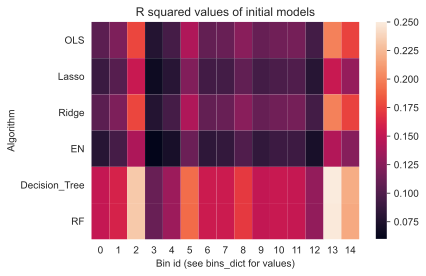

In [76]:
def plot_heatmap(results, 
                 save_figure=False, 
                 filename="Model test heatmap.png"):
    
    fig, ax = plt.subplots()

    sns.heatmap(results.set_index('bin_id').transpose(), ax=ax)
    plt.yticks(rotation=0)
    plt.ylabel("Algorithm")
    plt.xlabel("Bin id (see bins_dict for values)")
    plt.title("R squared values of initial models")
    
    if save_figure: 
        plt.savefig(filename)
plot_heatmap(results, 
             save_figure=True, 
             filename="Figures/model_selection_heatmap_282021")

In [64]:
# output tabular form of bins_dict

print("bins_dict (for easy reference): \n\n")
for k, v in bins_dict.items(): 
    print(f"bin_id: {k}")
    print(f"date ranges: {v}")

bins_dict (for easy reference): 


bin_id: 0
date ranges: [(0, 10), (11, 999)]
bin_id: 1
date ranges: [(0, 50), (51, 999)]
bin_id: 2
date ranges: [(0, 100), (101, 999)]
bin_id: 3
date ranges: [(0, 3), (4, 10), (11, 999)]
bin_id: 4
date ranges: [(0, 3), (4, 20), (21, 999)]
bin_id: 5
date ranges: [(0, 3), (4, 50), (51, 999)]
bin_id: 6
date ranges: [(0, 10), (11, 20), (21, 999)]
bin_id: 7
date ranges: [(0, 10), (11, 40), (41, 999)]
bin_id: 8
date ranges: [(0, 10), (11, 60), (61, 999)]
bin_id: 9
date ranges: [(0, 20), (21, 40), (41, 999)]
bin_id: 10
date ranges: [(0, 20), (21, 60), (61, 999)]
bin_id: 11
date ranges: [(0, 20), (21, 100), (101, 999)]
bin_id: 12
date ranges: [(0, 10), (11, 20), (21, 30), (31, 40), (41, 50), (51, 999)]
bin_id: 13
date ranges: [(0, 10), (11, 30), (31, 60), (61, 100), (101, 150), (151, 210), (211, 999)]
bin_id: 14
date ranges: [(0, 20), (21, 40), (41, 60), (61, 100), (101, 140), (141, 200), (201, 999)]


**Summary**
- Decision Tree and Random Forest (n=10) appear to be the best performing models thus far. 
- There is no significant improvement when using a Random Forest, so we will stick with Decision Trees. 
- The best performing bin distribution is bin_id = 13: [(0, 10), (11, 30), (31, 60), (61, 100), (101, 150), (151, 210), (211, 999)]
- While testing this function, repeated runs have demostrated that the R squared is changing enough such that each run may result in a different optimal bin distribution. In the next iteration of this project, I will train numerous decision trees on the same set of bins to characterize how the R squared value is changing. This is may be due to different datapoints being selected in the train/test split section. 

# 5 <a id='5'>Conclusions and Future Work</a>
[back to top](#top)<br>

To summarize, 2 datsets were cleaned: one on the covid-19 case and death numbers and another on policy data. The case and policy data were plotted at the county and state level and correlated with policy implementations. The numerous policy implementations were aggregated together to developed a model that correlated the change in new case and death numbers 7 days after a policy implementation. Finally, the categorical policy data was encoded and joined with the case and death numbers to develop a regression model meant to predict the number of new covid cases given historical policy implementations. The most promising cadidate thus far is a decision tree, with $R^2 \approx 0.25$.  

**TODO**
- Fix bug in section 2.2 (doesn't work when overlaying 3 or more policies)
- Write up descriptions of each algorithm used for my own edification
- Apply decision trees repeatedly to understand how and why the model performance is changing - likely due to the train-test-split. Will likely need to include cross-validation
- Try multiple bin distributions similar to the one(s) that gave the best results